## Custom model, train dataset 2 (2019+2020) with cropped black edges.

In [ ]:
import os
import gdown
import shutil
import numpy as np
import pandas as pd
import pathlib
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from tensorflow.keras.utils import save_img, img_to_array, array_to_img, load_img, image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, roc_curve, auc

In [ ]:
from data_processing_utils import show_dirs_len, prepocess_to_crop, separate_vignette_images, crop_and_save

from models_processing_utils import make_sructured_subset, make_balanced_sructured_subset, make_custom_sructured_subset,\
                                    augment_and_save, run_augmentation, run_selective_augmentation, add_files, sample_and_copy_files,\
                                    generate_model_version_name, binary_class_weights, binary_class_weights_2, initial_bias_calc, initial_bias_calc_2,\
                                    MetricsLogger, CustomCheckpoint, plot_scores, plot_loss, plot_confusion_matrix, fbeta_metric,\
                                    make_model, get_predictions_df, get_predictions_df2, show_predicted,\
                                    ModelEvaluating, ModelPredicting, ModelTraining,\
                                    scan_dataset, preprocess_image, split_by_class, stratified_dataset_from_directory


In [ ]:
# !pip install wandb

In [ ]:
# import wandb
# wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: syurt (syurt-institution) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
# wandb.init(project='melanoma_classification', settings=wandb.Settings(code_dir=None))
# from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

In [ ]:
# os.environ["WANDB_MODE"] = "dryrun"
# os.environ["WANDB_DIR"] = "/dev/null"
# os.environ["WANDB_DATA_DIR"] = "/dev/null"
# os.environ["WANDB_CONFIG_DIR"] = "/dev/null"

## Формування робочого датасету

Завантаження джерела

In [ ]:
# https://drive.google.com/file/d/1Wn-z5ozhs94Pfgrix70CiCcQGZdTXh3z/view?usp=sharing
file_id = "1Wn-z5ozhs94Pfgrix70CiCcQGZdTXh3z"
url = f"https://drive.google.com/uc?id={file_id}"
output = "2020_supplemented_cropped.zip"

gdown.download(url, output, quiet=False)


In [ ]:
!unzip -q 2020_supplemented_cropped.zip

In [ ]:
os.makedirs('2020_supplemented_cropped', exist_ok=True)
!mv /content/content/2020_supplemented/* /content/2020_supplemented_cropped/

In [ ]:
show_dirs_len(pathlib.Path("/content/2020_supplemented_cropped"))

.: 2
train: 2
train/melanoma: 5093
train/other: 32112
test: 2
test/melanoma: 1587
test/other: 10638


In [ ]:
# shutil.rmtree("/content/2020_supplemented_cropped")

In [ ]:
data_dir = pathlib.Path("/content/2020_supplemented_cropped")

Завантажити зображення з набору 2019 року з видаленими чорними краями в тренувальному наборі.

In [ ]:
# https://drive.google.com/file/d/1Qo98PZ2fsgsp-nEG6DW4XX5NtUb16xoi/view?usp=sharing
file_id = "1Qo98PZ2fsgsp-nEG6DW4XX5NtUb16xoi"
url = f"https://drive.google.com/uc?id={file_id}"
output = "2019_all_croppedtr.zip"

gdown.download(url, output, quiet=False)
!unzip -q 2019_all_croppedtr.zip

Downloading...
From (original): https://drive.google.com/uc?id=1Qo98PZ2fsgsp-nEG6DW4XX5NtUb16xoi
From (redirected): https://drive.google.com/uc?id=1Qo98PZ2fsgsp-nEG6DW4XX5NtUb16xoi&confirm=t&uuid=94ca40a8-7074-4743-a186-3d53ac35b5b3
To: /content/2019_all_croppedtr.zip
100%|██████████| 1.26G/1.26G [00:18<00:00, 69.1MB/s]


In [ ]:
show_dirs_len(pathlib.Path("/content/2019_all_croppedtr"))

.: 2
train: 2
train/melanoma: 4513
train/other: 20768
test: 2
test/melanoma: 1327
test/other: 6911


Об'єднати набори даних. В 2020 році, позитивний клас, вже присутні зображення 2019 року, тому доповнення тільки негативним класом.

In [ ]:
!mv /content/2019_all_croppedtr/train/other/* /content/2020_supplemented_cropped/train/other
!mv /content/2019_all_croppedtr/test/other/* /content/2020_supplemented_cropped/test/other

In [ ]:
show_dirs_len(data_dir)

.: 2
train: 2
train/melanoma: 5093
train/other: 52880
test: 2
test/melanoma: 1587
test/other: 17549


In [ ]:
# select in validation directory 40:60 proportion of classes
val_dir = data_dir / "validation"
train_dir = data_dir / "train"
num_melanoma = len(os.listdir(os.path.join(train_dir, "melanoma")))
num_other = len(os.listdir(os.path.join(train_dir, "other")))
k = num_melanoma/num_other if num_other > 0 else 1
print(f'Class proportion={k}')
rates_per_class = {
    "melanoma": 0.2,
    "other": 0.2*k*1.57
}
make_balanced_sructured_subset(train_dir, val_dir, 10, rates_per_class, copy=False)

Class proportion=0.09631240544629349


In [ ]:
show_dirs_len(data_dir)

.: 3
train: 2
train/melanoma: 4075
train/other: 51281
test: 2
test/melanoma: 1587
test/other: 17549
validation: 2
validation/melanoma: 1018
validation/other: 1599


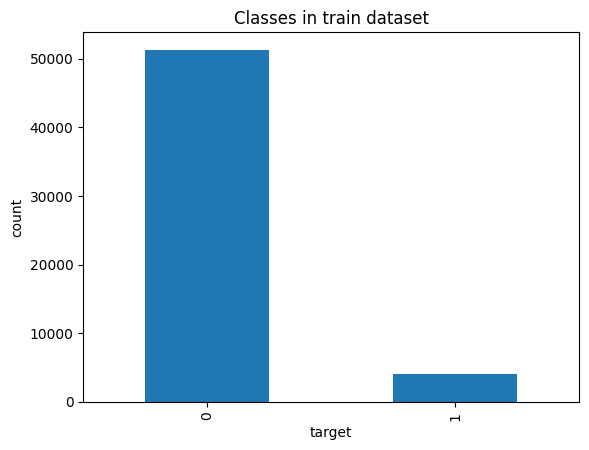

In [ ]:
tmp_df1 = pd.DataFrame({"image_name": os.listdir(data_dir / "train/melanoma"), "target": 1})
tmp_df2 = pd.DataFrame({"image_name": os.listdir(data_dir / "train/other"), "target": 0})
tmp_df_comb = pd.concat([tmp_df1, tmp_df2], ignore_index=True)
tmp_df_comb.target.value_counts().plot(kind='bar')
plt.title('Classes in train dataset')
plt.xlabel('target')
plt.ylabel('count')
plt.show()

## Завантаження даних для навчання

In [ ]:
# весь cropped датасет без аугментації
# https://drive.google.com/file/d/1vIdcm_P_m5jJxWtidqct1iy4VfiJfO4Y/view?usp=sharing
file_id = "1vIdcm_P_m5jJxWtidqct1iy4VfiJfO4Y"
url = f"https://drive.google.com/uc?id={file_id}"
output = "full_ds_croppedtr_no_augm.zip"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1vIdcm_P_m5jJxWtidqct1iy4VfiJfO4Y
From (redirected): https://drive.google.com/uc?id=1vIdcm_P_m5jJxWtidqct1iy4VfiJfO4Y&confirm=t&uuid=39aeb3e8-f8e4-4637-84d0-52340dada0a6
To: /content/full_ds_croppedtr_no_augm.zip
100%|██████████| 2.08G/2.08G [00:37<00:00, 55.3MB/s]


'full_ds_croppedtr_no_augm.zip'

In [ ]:
!unzip -q full_ds_croppedtr_no_augm.zip

In [ ]:
# датасет prove_ai для доповнення валідаційних даних
# https://https://drive.google.com/file/d/1K2IrjUHuHl1Nn-t0aUMGXOvytSABf108/view?usp=sharing
file_id = "1K2IrjUHuHl1Nn-t0aUMGXOvytSABf108"
url = f"https://drive.google.com/uc?id={file_id}"
output = "prove_ai_split.zip"

gdown.download(url, output, quiet=False)
!unzip -q prove_ai_split.zip

Downloading...
From: https://drive.google.com/uc?id=1K2IrjUHuHl1Nn-t0aUMGXOvytSABf108
To: /content/prove_ai_split.zip
100%|██████████| 15.5M/15.5M [00:00<00:00, 39.0MB/s]


In [ ]:
# додати валідаційні дані
source_dir = pathlib.Path("/content/prove_ai_split/validation/other")
dest_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm/validation/other")
add_files(source_dir, dest_dir)
source_dir1 = pathlib.Path("/content/prove_ai_split/validation/melanoma")
dest_dir1 = pathlib.Path("/content/full_ds_croppedtr_no_augm/validation/melanoma")
add_files(source_dir1, dest_dir1)

In [ ]:
# весь cropped датасет melanoma class з аугментацією 1:5
# https://drive.google.com/file/d/1iGY_AW2F4UolnGNb61pybA5pOFAEhOKu/view?usp=sharing
file_id = "1iGY_AW2F4UolnGNb61pybA5pOFAEhOKu"
url = f"https://drive.google.com/uc?id={file_id}"
output = "melanoma_augmented_cropped5v2.zip"

gdown.download(url, output, quiet=False)
!unzip -q melanoma_augmented_cropped5v2.zip

Downloading...
From (original): https://drive.google.com/uc?id=1iGY_AW2F4UolnGNb61pybA5pOFAEhOKu
From (redirected): https://drive.google.com/uc?id=1iGY_AW2F4UolnGNb61pybA5pOFAEhOKu&confirm=t&uuid=2ea0558b-6517-4693-9d54-ac849d7c1641
To: /content/melanoma_augmented_cropped5v2.zip
100%|██████████| 156M/156M [00:02<00:00, 74.3MB/s]


In [ ]:
# додати аугментовані файли у датасет (якщо не використовується додаткова аугментація, а тільки version2)
dest_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm/train/melanoma")
source_dir = pathlib.Path("/content/melanoma_augmented_cropped5v2")
add_files(source_dir, dest_dir)

In [ ]:
data_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm")
show_dirs_len(data_dir)

.: 3
test: 2
test/other: 17549
test/melanoma: 1587
validation: 2
validation/other: 1599
validation/melanoma: 1018
train: 2
train/other: 51281
train/melanoma: 4075


### Додавання додаткової аугментації

In [ ]:
# version3 аугментації (+ аугментація негативного класу)
# https://drive.google.com/file/d/1kIKi-e-VLdS2PMibkfXpVWfPEMuBsxja/view?usp=sharing

file_id = "1kIKi-e-VLdS2PMibkfXpVWfPEMuBsxja"
url = f"https://drive.google.com/uc?id={file_id}"
output = "augmented_cropped5v3.zip"

gdown.download(url, output, quiet=False)
!unzip -q augmented_cropped5v3.zip

Downloading...
From (original): https://drive.google.com/uc?id=1kIKi-e-VLdS2PMibkfXpVWfPEMuBsxja
From (redirected): https://drive.google.com/uc?id=1kIKi-e-VLdS2PMibkfXpVWfPEMuBsxja&confirm=t&uuid=231884eb-4c30-44a7-8219-c28476d44934
To: /content/augmented_cropped5v3.zip
100%|██████████| 546M/546M [00:05<00:00, 95.1MB/s]


In [ ]:
# додати аугментовані дані в клас other ВСІ
source_dir = pathlib.Path("/content/augmented/train/other")
dest_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm/train/other")
add_files(source_dir, dest_dir)

In [ ]:
# додати ЧАСТИНУ аугментованих даних в клас other
source_dir = pathlib.Path("/content/augmented/train/other")
dest_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm/train/other")
sample_and_copy_files(source_dir, dest_dir, ratio=0.25)

In [ ]:
# додати аугментовані дані класу melanoma v2
dest_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm/train/melanoma")
source_dir = pathlib.Path("/content/melanoma_augmented_cropped5v2")
# source_dir = pathlib.Path("/content/augmented_cropped5v3/augmented/train/melanoma")
add_files(source_dir, dest_dir)

In [ ]:
#якщо потрібно використати ВСІ зображеня версії 3 аугментації меланоми
dest_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm/train/melanoma")
source_dir = pathlib.Path("/content/augmented/train/melanoma")
add_files(source_dir, dest_dir, suffix='v3')

In [ ]:
#якщо потрібно використати обидві версії аугментації меланоми без заміни з додаванням частини V3
dest_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm/train/melanoma")
source_dir = pathlib.Path("/content/augmented/train/melanoma")
sample_and_copy_files(source_dir, dest_dir, ratio=0.5, suffix='v3')

In [ ]:
# відібрати частину аугментованих даних v3, класу меланома та домішати з заміною v2
dest_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm/train/melanoma")
source_dir = pathlib.Path("/content/augmented/train/melanoma")
sample_and_copy_files(source_dir, dest_dir, ratio=0.7)

In [ ]:
# відібрати частину аугментованих даних v2, класу меланома та домішати з заміною v3
dest_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm/train/melanoma")
source_dir = pathlib.Path("/content/melanoma_augmented_cropped5v2")
sample_and_copy_files(source_dir, dest_dir, ratio=0.5)

In [ ]:
# додати аугментовані файли у датасет (клас melanoma)
# dest_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm/train/melanoma")
# source_dir = pathlib.Path("/content/augm_mix_mel")
# add_files(source_dir, dest_dir)

In [ ]:
data_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm")
show_dirs_len(data_dir)

.: 3
test: 2
test/other: 17549
test/melanoma: 1587
validation: 2
validation/other: 1599
validation/melanoma: 1018
train: 2
train/other: 76921
train/melanoma: 24450


## Визначення параметрів для побудови моделі, розбиття датасету

In [ ]:
data_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm")
show_dirs_len(data_dir)

.: 3
test: 2
test/other: 17549
test/melanoma: 1587
validation: 2
validation/other: 2107
validation/melanoma: 1113
train: 2
train/other: 64101
train/melanoma: 34637


In [ ]:
IM_SIZE = 256
BATCH_SIZE = 32
VERSION = generate_model_version_name()
MODEL_NAME = f"Custom_model_{VERSION}"
LEARNING_RATE = 3e-4

In [ ]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]

In [ ]:
# if full train_ds
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "train",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  shuffle=True,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "validation",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

Found 98738 files belonging to 2 classes.
Found 3220 files belonging to 2 classes.
Found 19136 files belonging to 2 classes.


### Візуалізація датасету

In [ ]:
class_names = train_ds.class_names
print(class_names)

['other', 'melanoma']


In [ ]:
print(train_ds)
print(val_ds)
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


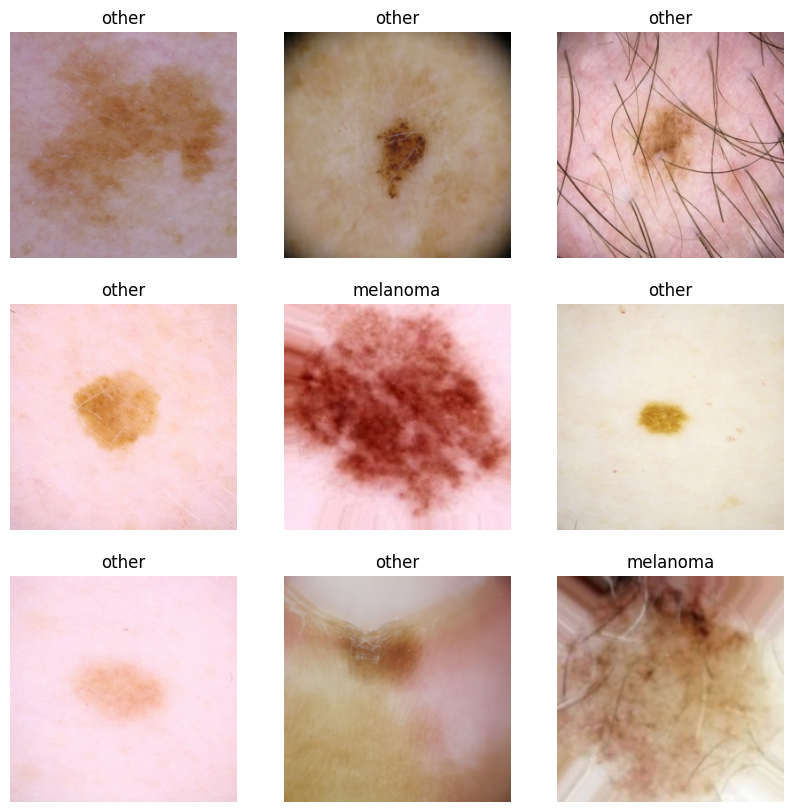

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Створення моделі, передобробка датасету, навчання, оцінка

In [ ]:
# Configure the dataset for performance
train_ds = train_ds.shuffle(64).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

### при дисбалансі класів

In [ ]:
count_1 = len(os.listdir(data_dir / "train/melanoma"))
count_0 = len(os.listdir(data_dir / "train/other"))

In [ ]:
# weight_0, weight_1 = binary_class_weights(train_ds)
weight_0, weight_1 = binary_class_weights_2(count_1, count_0)

class_weights = {0: weight_0, 1: weight_1}

print(f'Weight for class 0: {weight_0:.2f}')
print(f'Weight for class 1: {weight_1:.2f}')

Weight for class 0: 0.77
Weight for class 1: 1.43


In [ ]:
# initial_bias = initial_bias_calc(train_ds)
initial_bias = initial_bias_calc_2(count_1, count_0)
print(f'initial_bias: {initial_bias}')

initial_bias: -1.1461487052352126


### Модель

In [ ]:
@register_keras_serializable()
class ConvDepthwiseConvBlock(layers.Layer):
    def __init__(self, filters, scale=1, kernel_size=3, strides=1, activation="silu", kernel_regularizer=None, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.filters = filters
        self.scale = scale
        self.kernel_size = kernel_size
        self.strides = strides
        self.activation = keras.activations.get(activation)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

        self.conv1 = None
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.Activation(self.activation)

        self.dw_conv = None
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.Activation(self.activation)

        self.conv2 = None
        self.bn3 = layers.BatchNormalization()
        self.act3 = layers.Activation(self.activation)

    def build(self, input_shape):
        self.conv1 = layers.Conv2D(filters=self.filters*self.scale,
                                   kernel_size=self.kernel_size,
                                   strides=self.strides,
                                   padding="same",
                                   kernel_regularizer=self.kernel_regularizer)

        self.dw_conv = layers.DepthwiseConv2D(kernel_size=self.kernel_size,
                                              strides=1,
                                              padding="same",
                                              depthwise_regularizer=self.kernel_regularizer)

        self.conv2 = layers.Conv2D(filters=self.filters,
                                   kernel_size=self.kernel_size,
                                   strides=1, padding="same",
                                   kernel_regularizer=self.kernel_regularizer)
        super().build(input_shape)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.dw_conv(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.conv2(x)
        x = self.bn3(x)
        x = self.act3(x)
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "filters": self.filters,
            "scale": self.scale,
            "kernel_size": self.kernel_size,
            "strides": self.strides,
            "kernel_regularizer": keras.regularizers.serialize(self.kernel_regularizer),
        })
        return config

In [ ]:
@register_keras_serializable()
class CBAM(layers.Layer):
    def __init__(self, reduction_ratio=8,  kernel_size=7, name="cbam", kernel_regularizer=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.reduction_ratio = reduction_ratio
        self.kernel_size = kernel_size
        self.kernel_regularizer=keras.regularizers.get(kernel_regularizer)

    def build(self, input_shape):
        channel = input_shape[-1]

        # Channel Attention
        self.global_avg_pool = layers.GlobalAveragePooling2D() #squeeze in one vector (batch_size, channels), avg each feature map (channel) of all pixls
        self.global_max_pool = layers.GlobalMaxPooling2D()

        #multy-layers perceptron
        self.shared_mlp = tf.keras.Sequential([
            layers.Dense(channel // self.reduction_ratio, activation='relu', kernel_regularizer=self.kernel_regularizer),
            layers.Dense(channel, kernel_regularizer=self.kernel_regularizer)
        ])

        self.reshape = layers.Reshape((1, 1, channel))

        # Spatial Attention
        self.conv_spatial = layers.Conv2D(filters=1,
                                  kernel_size=self.kernel_size,
                                  strides=1,
                                  padding='same',
                                  activation='sigmoid',
                                  kernel_regularizer=self.kernel_regularizer)

    def call(self, inputs, return_attention=False):
        # Channel Attention
        avg_pool = self.global_avg_pool(inputs)
        max_pool = self.global_max_pool(inputs)

        avg_full_conn = self.shared_mlp(avg_pool)
        max_full_conn = self.shared_mlp(max_pool)

        channel_attention = tf.keras.activations.sigmoid(avg_full_conn + max_full_conn)
        channel_attention = self.reshape(channel_attention)
        x = inputs * channel_attention  # Broadcasted multiplication

        # Spatial Attention
        avg_pool_spatial = tf.reduce_mean(x, axis=-1, keepdims=True) # карта ознак (batch_size, height, width, 1), avg of all channels
        max_pool_spatial = tf.reduce_max(x, axis=-1, keepdims=True)
        spatial_attention = tf.concat([avg_pool_spatial, max_pool_spatial], axis=-1)

        spatial_attention = self.conv_spatial(spatial_attention)
        x = x * spatial_attention  # Element-wise multiplication

        if return_attention:
            return x, channel_attention, spatial_attention
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "reduction_ratio": self.reduction_ratio,
            "kernel_regularizer": keras.regularizers.serialize(self.kernel_regularizer),
            "kernel_size": self.kernel_size,
        })
        return config


In [ ]:
def Custom_CNN(input_shape=(256, 256, 3), reduction=8, use_regularization=False, weight_decay=1e-4):
    regularizer = l2(weight_decay) if use_regularization else None

    inputs = layers.Input(shape=input_shape)
    resize_rescale = tf.keras.Sequential([
                      layers.Resizing(input_shape[0], input_shape[1]),
                      layers.Rescaling(1./255)
                    ], name="resize_rescale")
    x = resize_rescale(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", kernel_regularizer=regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('silu')(x)

    x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", kernel_regularizer=regularizer)(x) #128
    x = layers.BatchNormalization()(x)
    x = layers.Activation('silu')(x)
    x = layers.DepthwiseConv2D(kernel_size=3, strides=1, padding="same", depthwise_regularizer=regularizer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('silu')(x)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x) #(64,64,32)
    res1 = x

    x = ConvDepthwiseConvBlock(32, scale=2, kernel_size=3, strides=1, name="ConvDeptConv1", kernel_regularizer=regularizer)(x) #(64,64,32)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x) #(32,32,32)
    res2 = x
    res1 = layers.Conv2D(filters=32, kernel_size=1, strides=2, padding="same", kernel_regularizer=regularizer)(res1) #(32,32,32)
    x = CBAM(reduction_ratio=reduction//2, name="cbam1")(x)
    x = layers.Add()([x, res1]) #(32,32,32)

    x = ConvDepthwiseConvBlock(32, scale=4, kernel_size=3, strides=1,  name="ConvDeptConv2", kernel_regularizer=regularizer)(x) #(32,32,32)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x) #(16,16,32)
    res3 = x
    res2 = layers.Conv2D(filters=32, kernel_size=1, strides=2, padding="same", kernel_regularizer=regularizer)(res2) #(16,16,32)
    x = CBAM(reduction_ratio=reduction//2, name="cbam2")(x)
    x = layers.Add()([x, res2]) #(16,16,32)
    x = layers.Dropout(0.1)(x)

    x = ConvDepthwiseConvBlock(64, scale=4, kernel_size=2, strides=1, name="ConvDeptConv3", kernel_regularizer=regularizer)(x) #(16,16,64)
    x = layers.MaxPooling2D(pool_size=2, padding="same")(x) #(8,8,64)
    res4 = x
    res3 = layers.Conv2D(filters=64, kernel_size=1, strides=2, padding="same", kernel_regularizer=regularizer)(res3) #(8,8,64)
    x = CBAM(reduction_ratio=reduction, name="cbam3")(x)
    x = layers.Add()([x, res3]) #(8,8,64)
    x = layers.Dropout(0.15)(x)

    x = ConvDepthwiseConvBlock(128, scale=4, kernel_size=2, strides=1, name="ConvDeptConv4", kernel_regularizer=regularizer)(x) #(8,8,128)
    x = CBAM(reduction_ratio=reduction,  name="cbam4")(x)
    res4 = layers.Conv2D(filters=128, kernel_size=1, strides=1, padding="same", kernel_regularizer=regularizer)(res4) #(8,8,128)
    x = layers.Add()([x, res4]) #(8,8,128)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(filters=256, kernel_size=2, strides=1, padding="same", kernel_regularizer=regularizer)(x) #8, 256
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu', name='full_con', kernel_regularizer=regularizer)(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid', name='pred')(x)

    model = tf.keras.Model(inputs, outputs, name="custome_model")
    return model

## Навчання 2

In [ ]:
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    bce = tf.keras.losses.BinaryCrossentropy()
    bce_loss = bce(y_true, y_pred)

    # ймовірність правильного класу
    ptrue = tf.where(y_true == 1, y_pred, 1 - y_pred)

    # Фокус-фактор на складні приклади
    focal_factor = (1 - ptrue) ** gamma

    return alpha * focal_factor * bce_loss

In [ ]:
custom_model = Custom_CNN(input_shape=(IM_SIZE, IM_SIZE, 3), reduction=4)
custom_model.load_weights('/content/Custome_CNN_05-11-17.keras')

In [ ]:
# custom_model = make_model(learning_rate=LEARNING_RATE, loss_func=keras.losses.BinaryCrossentropy(), metrics=METRICS, model=custom_model, output_bias=initial_bias)
custom_model.summary(show_trainable=True)

Model: "custome_model"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 256,     │         0 │ -              │   -   │
│ (InputLayer)      │ 256, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ resize_rescale    │ (None, 256,     │         0 │ input_layer[0… │   -   │
│ (Sequential)      │ 256, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 256,     │       896 │ resize_rescal… │   Y   │
│                   │ 256, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 256,     │       128 │ conv2d[0][0]   │   Y   │
│ (BatchNormalizat… │ 256, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation        │ (None, 256,     │         0 │ batch_normali… │   -   │
│ (Activation)      │ 256, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 128,     │     9,248 │ activation[0]… │   Y   │
│                   │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 128,     │       128 │ conv2d_1[0][0] │   Y   │
│ (BatchNormalizat… │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_1      │ (None, 128,     │         0 │ batch_normali… │   -   │
│ (Activation)      │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ depthwise_conv2d  │ (None, 128,     │       320 │ activation_1[… │   Y   │
│ (DepthwiseConv2D) │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 128,     │       128 │ depthwise_con… │   Y   │
│ (BatchNormalizat… │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_2      │ (None, 128,     │         0 │ batch_normali… │   -   │
│ (Activation)      │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ ConvDeptConv1     │ (None, 64, 64,  │    38,240 │ activation_2[… │   Y   │
│ (ConvDepthwiseCo… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 64, 64,  │         0 │ activation_2[… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 64, 64,  │         0 │ ConvDeptConv1… │   -   │
│                   │ 32)             │           │ max_pooling2d… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ ConvDeptConv2     │ (None, 32, 32,  │    76,320 │ add[0][0]      │   Y   │
│ (ConvDepthwiseCo… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ cbam1 (CBAM)      │ (None, 32, 32,  │     1,171 │ ConvDeptConv2… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add_1 (Add)       │ (None, 32, 32,  │         0 │ cbam1[0][0],   │   - 

 Total params: 957,930 (3.65 MB)

 Trainable params: 952,874 (3.63 MB)

 Non-trainable params: 5,056 (19.75 KB)

In [ ]:
filepath = f'/content/{MODEL_NAME}_2_best_metric.keras'

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=LEARNING_RATE,
#     decay_steps=3167,
#     decay_rate=0.95
# )

optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

custom_checkpoint = CustomCheckpoint(filepath=filepath, monitor_metric='val_auc')

callbacks_list = [EarlyStopping(monitor='val_auc', patience=4),
                  ModelCheckpoint(f'{MODEL_NAME}.keras', monitor='val_loss', save_best_only=True),
                  custom_checkpoint]

epochs=20

Custom_model_05-17-08
Epoch 1/20
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 348s 101ms/step - accuracy: 0.8655 - auc: 0.9332 - fn: 2523.9417 - fp: 4255.6650 - loss: 0.2993 - prc: 0.8926 - precision: 0.7875 - recall: 0.8423 - tn: 29931.7383 - tp: 15916.3906 - val_accuracy: 0.7429 - val_auc: 0.8566 - val_fn: 799.0000 - val_fp: 29.0000 - val_loss: 0.5597 - val_prc: 0.7763 - val_precision: 0.9155 - val_recall: 0.2821 - val_tn: 2078.0000 - val_tp: 314.0000
Epoch 2/20
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 295s 95ms/step - accuracy: 0.8859 - auc: 0.9536 - fn: 1793.0178 - fp: 3808.5886 - loss: 0.2746 - prc: 0.9209 - precision: 0.8011 - recall: 0.8962 - tn: 28273.2637 - tp: 15532.9873 - val_accuracy: 0.7724 - val_auc: 0.8611 - val_fn: 661.0000 - val_fp: 72.0000 - val_loss: 0.4722 - val_prc: 0.7868 - val_precision: 0.8626 - val_recall: 0.4061 - val_tn: 2035.0000 - val_tp: 452.0000
Epoch 3/20
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 322s 95ms/step - accuracy: 0.8888 - auc: 0.9566 - fn: 1756.8905 - fp: 3687.2737 - loss: 0.264

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

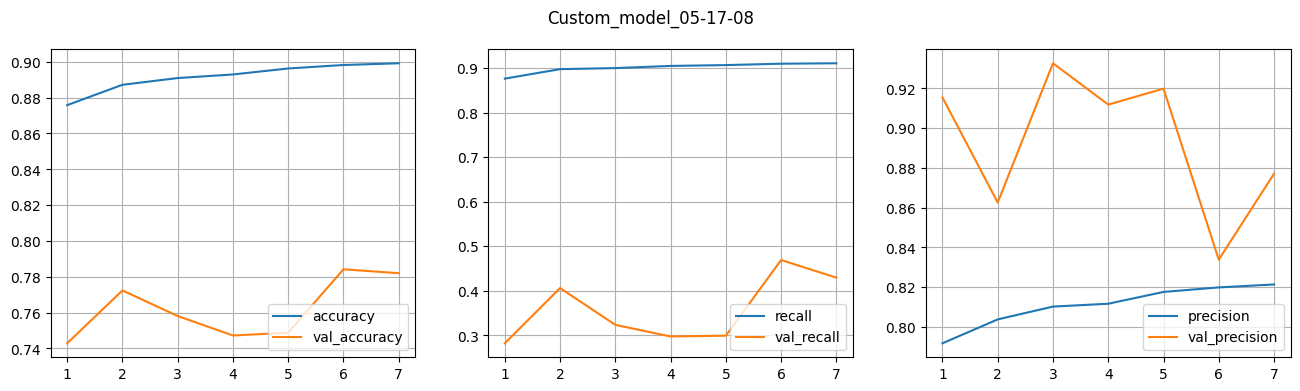

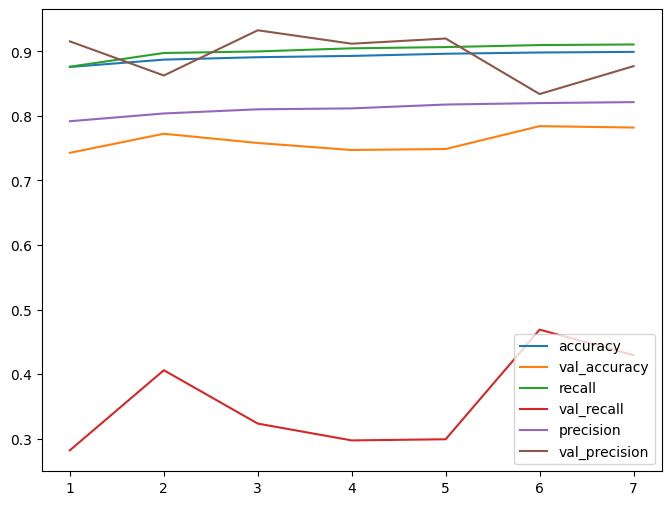

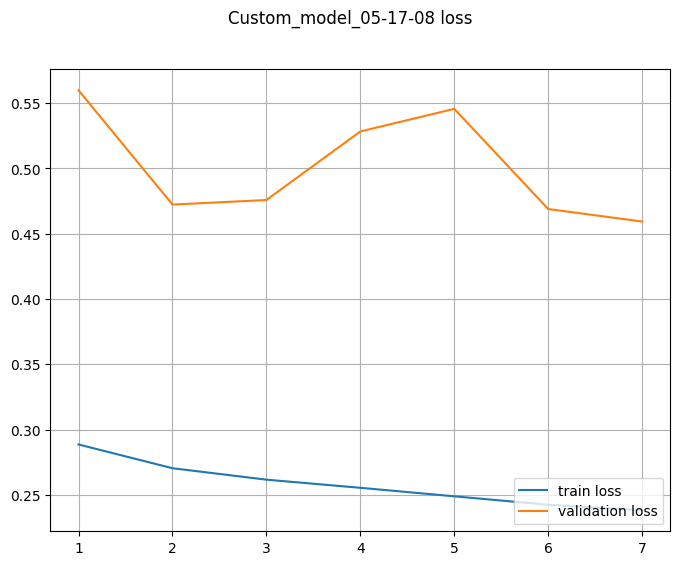

In [ ]:
history = ModelTraining(train_ds, val_ds, custom_model, show_summary=False,
              model_name=MODEL_NAME, optimizer=optimizer,
              loss=focal_loss, metrics=METRICS, output_bias=None,
              class_weights=class_weights, callbacks_list=callbacks_list, epochs=epochs)


In [ ]:
model_path = f"/content/{MODEL_NAME}.keras"
model_best_loss = keras.models.load_model(model_path, custom_objects={"ConvDeptConv": ConvDepthwiseConvBlock, "cbam": CBAM})

best_loss_model_res = ModelEvaluating(test_ds,
                           model_best_loss, model_name=MODEL_NAME,
                           metrics=METRICS)

598/598 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - accuracy: 0.9162 - auc: 0.8174 - fn: 496.6928 - fp: 293.7229 - loss: 0.2450 - prc: 0.4040 - precision: 0.4900 - recall: 0.3612 - tn: 8520.6289 - tp: 288.9015
loss :  0.24013222754001617
accuracy :  0.9174853563308716
precision :  0.5034542083740234
recall :  0.36735978722572327
tp :  583.0
fp :  575.0
tn :  16974.0
fn :  1004.0
auc :  0.8253650069236755
prc :  0.4181724786758423
f1_beta :  0.38835596918071497


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_path2 = f"/content/{MODEL_NAME}_2_best_metric.keras"
model_best_metric = keras.models.load_model(model_path2, custom_objects={"ConvDeptConv": ConvDepthwiseConvBlock, "cbam": CBAM})

best_metric_model_res = ModelEvaluating(test_ds,
                           model_best_metric, model_name=MODEL_NAME+'_2_best_metric',
                           metrics=METRICS)

598/598 ━━━━━━━━━━━━━━━━━━━━ 28s 41ms/step - accuracy: 0.9191 - auc: 0.8240 - fn: 539.1453 - fp: 220.5042 - loss: 0.2366 - prc: 0.4000 - precision: 0.5188 - recall: 0.3058 - tn: 8593.2373 - tp: 247.0601
loss :  0.23212465643882751
accuracy :  0.9209343791007996
precision :  0.5403050184249878
recall :  0.31253936886787415
tp :  496.0
fp :  422.0
tn :  17127.0
fn :  1091.0
auc :  0.8300852179527283
prc :  0.4152442514896393
f1_beta :  0.3413157046495252


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
IM_SIZE = 256
BATCH_SIZE = 32
VERSION = generate_model_version_name()
MODEL_NAME = f"Custome_CNN_{VERSION}"
LEARNING_RATE = 5e-5

# if full train_ds
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "train",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  shuffle=True,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "validation",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

# Configure the dataset for performance
train_ds = train_ds.shuffle(64).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# weight_0, weight_1 = binary_class_weights(train_ds)
weight_0, weight_1 = binary_class_weights_2(count_1, count_0)

class_weights = {0: weight_0, 1: weight_1}

print(f'Weight for class 0: {weight_0:.2f}')
print(f'Weight for class 1: {weight_1:.2f}')

# initial_bias = initial_bias_calc_2(count_1, count_0)
# print(f'initial_bias: {initial_bias}')

# custom_model = Custom_CNN(input_shape=(IM_SIZE, IM_SIZE, 3), reduction=4, use_regularization=True, weight_decay=1e-2)
custom_model = keras.models.load_model(model_path, custom_objects={"ConvDeptConv": ConvDepthwiseConvBlock, "cbam": CBAM})

custom_model.summary(show_trainable=True)

filepath = f'/content/{MODEL_NAME}_2_best_metric.keras'

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=7400,
    decay_rate=0.95
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, weight_decay=0.01)

custom_checkpoint = CustomCheckpoint(filepath=filepath, monitor_metric='val_auc')

callbacks_list = [EarlyStopping(monitor='val_auc', patience=8),
                  ModelCheckpoint(f'{MODEL_NAME}.keras', monitor='val_loss', save_best_only=True),
                  custom_checkpoint]

epochs=20

### Додати регуляризацію, dropout, заморозка cbam, більш збалансовані дані

In [ ]:
data_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm")
show_dirs_len(data_dir)

.: 3
test: 2
test/other: 17549
test/melanoma: 1587
validation: 2
validation/other: 1599
validation/melanoma: 1018
train: 2
train/other: 64101
train/melanoma: 34637


In [ ]:
IM_SIZE = 256
BATCH_SIZE = 32
VERSION = generate_model_version_name()
MODEL_NAME = f"Custome_CNN_{VERSION}"
LEARNING_RATE = 5e-5

In [ ]:
# if full train_ds
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "train",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  shuffle=True,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "validation",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

# Configure the dataset for performance
train_ds = train_ds.shuffle(64).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 88551 files belonging to 2 classes.
Found 2617 files belonging to 2 classes.
Found 19136 files belonging to 2 classes.


In [ ]:
# weight_0, weight_1 = binary_class_weights(train_ds)
weight_0, weight_1 = binary_class_weights_2(count_1, count_0)

class_weights = {0: weight_0, 1: weight_1}

print(f'Weight for class 0: {weight_0:.2f}')
print(f'Weight for class 1: {weight_1:.2f}')

# initial_bias = initial_bias_calc(train_ds)
initial_bias = initial_bias_calc_2(count_1, count_0)
print(f'initial_bias: {initial_bias}')

Weight for class 0: 0.69
Weight for class 1: 1.81
initial_bias: -0.9638297485080798


In [ ]:
custom_model = Custom_CNN(input_shape=(IM_SIZE, IM_SIZE, 3), reduction=4, use_regularization=True, weight_decay=1e-4)

In [ ]:
# Заморозка CBAM-блоків
for layer in custom_model.layers:
    if isinstance(layer, CBAM):
        layer.trainable = False

In [ ]:
custom_model.summary(show_trainable=True)

Model: "custome_model"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 256,     │         0 │ -              │   -   │
│ (InputLayer)      │ 256, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ resize_rescale    │ (None, 256,     │         0 │ input_layer[0… │   -   │
│ (Sequential)      │ 256, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 256,     │       896 │ resize_rescal… │   Y   │
│                   │ 256, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 256,     │       128 │ conv2d[0][0]   │   Y   │
│ (BatchNormalizat… │ 256, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation        │ (None, 256,     │         0 │ batch_normali… │   -   │
│ (Activation)      │ 256, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 128,     │     9,248 │ activation[0]… │   Y   │
│                   │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 128,     │       128 │ conv2d_1[0][0] │   Y   │
│ (BatchNormalizat… │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_1      │ (None, 128,     │         0 │ batch_normali… │   -   │
│ (Activation)      │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ depthwise_conv2d  │ (None, 128,     │       320 │ activation_1[… │   Y   │
│ (DepthwiseConv2D) │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 128,     │       128 │ depthwise_con… │   Y   │
│ (BatchNormalizat… │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_2      │ (None, 128,     │         0 │ batch_normali… │   -   │
│ (Activation)      │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ ConvDeptConv1     │ (None, 64, 64,  │    38,240 │ activation_2[… │   Y   │
│ (ConvDepthwiseCo… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 64, 64,  │         0 │ activation_2[… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 64, 64,  │         0 │ ConvDeptConv1… │   -   │
│                   │ 32)             │           │ max_pooling2d… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ ConvDeptConv2     │ (None, 32, 32,  │    76,320 │ add[0][0]      │   Y   │
│ (ConvDepthwiseCo… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ cbam1 (CBAM)      │ (None, 32, 32,  │     1,171 │ ConvDeptConv2… │   N   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout (Dropout) │ (None, 32, 32,  │         0 │ ConvDeptConv2… │   - 

 Total params: 953,194 (3.64 MB)

 Trainable params: 936,289 (3.57 MB)

 Non-trainable params: 16,905 (66.04 KB)

!define fit parameters

In [ ]:
history = ModelTraining(train_ds, val_ds, custom_model, show_summary=False,
              model_name=MODEL_NAME, optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS, output_bias=initial_bias,
              class_weights=class_weights, callbacks_list=callbacks_list, epochs=epochs)

Custome_CNN_05-11-07
Epoch 1/20
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8118 - auc: 0.8718 - fn: 2586.7720 - fp: 4779.6689 - loss: 0.5266 - prc: 0.7637 - precision: 0.6312 - recall: 0.7340 - tn: 27276.2324 - tp: 9660.8926
 Model saved on epoch 1 (val_auc: 0.8603)
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 357s 112ms/step - accuracy: 0.8118 - auc: 0.8718 - fn: 2587.4724 - fp: 4781.0825 - loss: 0.5265 - prc: 0.7638 - precision: 0.6312 - recall: 0.7340 - tn: 27286.3926 - tp: 9664.5986 - val_accuracy: 0.7489 - val_auc: 0.8603 - val_fn: 568.0000 - val_fp: 89.0000 - val_loss: 0.6089 - val_prc: 0.7919 - val_precision: 0.8349 - val_recall: 0.4420 - val_tn: 1510.0000 - val_tp: 450.0000
Epoch 2/20
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8764 - auc: 0.9442 - fn: 1804.6279 - fp: 3642.1504 - loss: 0.3920 - prc: 0.8939 - precision: 0.7395 - recall: 0.8524 - tn: 28412.4824 - tp: 10444.4512
 Model saved on epoch 2 (val_auc: 0.8783)
2768/2768 ━━━━━━━━━━━━━━━━━━━━ 274s 98ms/step

KeyboardInterrupt: 

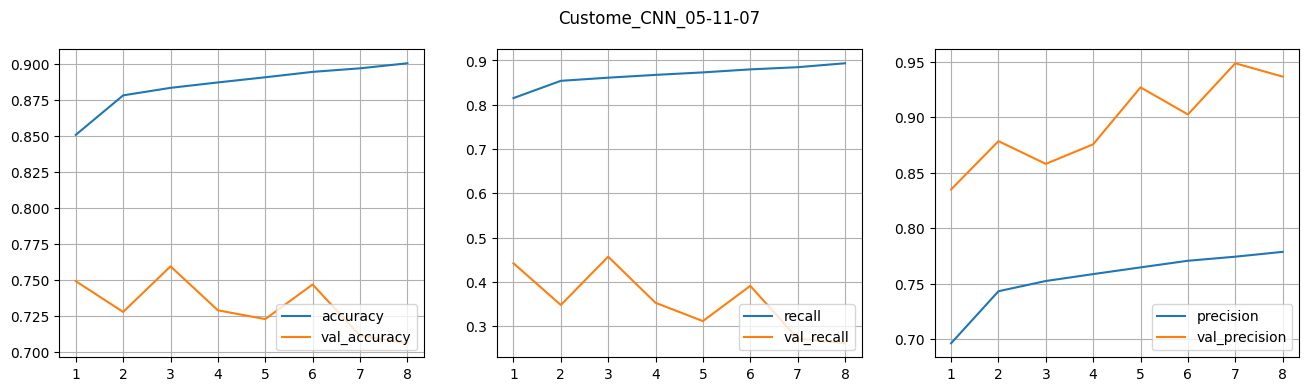

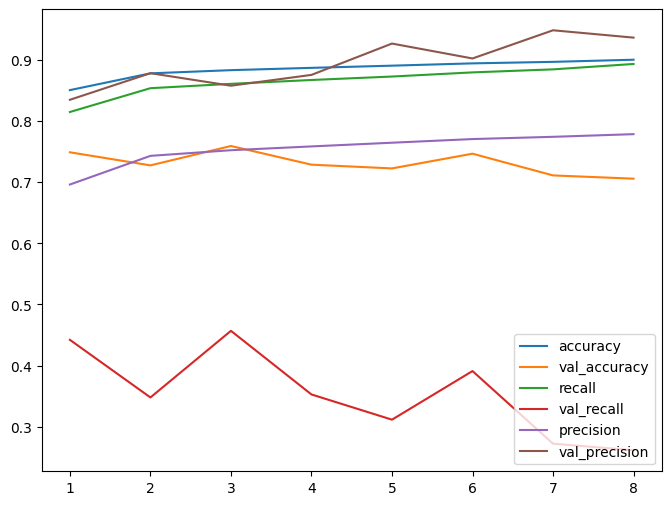

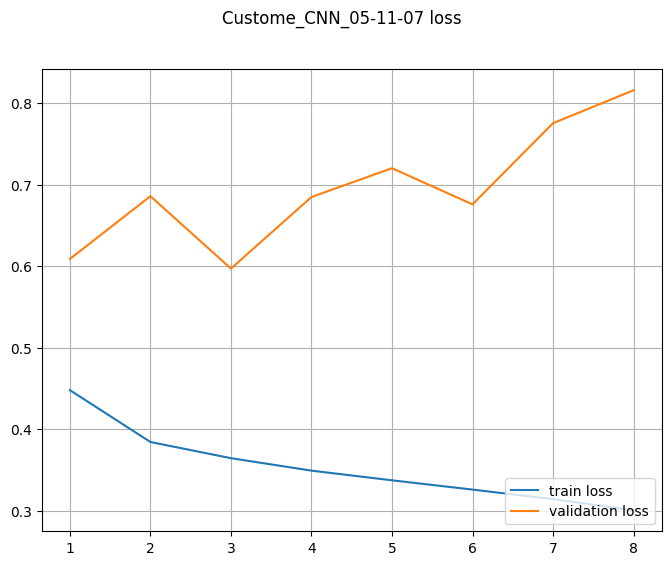

In [ ]:
df = pd.read_csv("/content/metrics_logs_Custome_CNN_05-11-07.csv")
MODEL_NAME = "Custome_CNN_05-11-07"
plot_scores (df, MODEL_NAME, ['accuracy', 'recall', 'precision'])
plot_loss(df, MODEL_NAME)

Модель все більше віддає перевагу негативному класу, FN збільшується.

### Навчання 3 після заміни на max pooling conv шарів з stride2 та додавання регуляризації

In [ ]:
#  ReduceLROnPlateau(factor=0.7, patience=5, min_lr=1e-6)

In [ ]:
data_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm")
show_dirs_len(data_dir)

.: 3
test: 2
test/other: 17549
test/melanoma: 1587
validation: 2
validation/other: 2107
validation/melanoma: 1113
train: 2
train/other: 51281
train/melanoma: 4075


In [ ]:
IM_SIZE = 256
BATCH_SIZE = 32
VERSION = generate_model_version_name()
MODEL_NAME = f"Custome_CNN_{VERSION}"
LEARNING_RATE = 3e-4

# if full train_ds
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "train",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  shuffle=True,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "validation",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

# Configure the dataset for performance
train_ds = train_ds.shuffle(64).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# weight_0, weight_1 = binary_class_weights(train_ds)
weight_0, weight_1 = binary_class_weights_2(count_1, count_0)

class_weights = {0: weight_0, 1: weight_1}

print(f'Weight for class 0: {weight_0:.2f}')
print(f'Weight for class 1: {weight_1:.2f}')

# initial_bias = initial_bias_calc(train_ds)
initial_bias = initial_bias_calc_2(count_1, count_0)
print(f'initial_bias: {initial_bias}')

custom_model = Custom_CNN(input_shape=(IM_SIZE, IM_SIZE, 3), reduction=4, use_regularization=True, weight_decay=1e-2)

custom_model.summary(show_trainable=True)

filepath = f'/content/{MODEL_NAME}_2_best_metric.keras'

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=3800,
    decay_rate=0.95
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, weight_decay=0.01)

custom_checkpoint = CustomCheckpoint(filepath=filepath, monitor_metric='val_auc')

callbacks_list = [EarlyStopping(monitor='val_auc', patience=4),
                  ModelCheckpoint(f'{MODEL_NAME}.keras', monitor='val_loss', save_best_only=True),
                  custom_checkpoint]

epochs=20

Found 121746 files belonging to 2 classes.
Found 2617 files belonging to 2 classes.
Found 19136 files belonging to 2 classes.
Weight for class 0: 0.79
Weight for class 1: 1.36
initial_bias: -0.5400129016648972


Model: "custome_model"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 256,     │         0 │ -              │   -   │
│ (InputLayer)      │ 256, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ resize_rescale    │ (None, 256,     │         0 │ input_layer[0… │   -   │
│ (Sequential)      │ 256, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 256,     │       896 │ resize_rescal… │   Y   │
│                   │ 256, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 256,     │       128 │ conv2d[0][0]   │   Y   │
│ (BatchNormalizat… │ 256, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation        │ (None, 256,     │         0 │ batch_normali… │   -   │
│ (Activation)      │ 256, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 128,     │     9,248 │ activation[0]… │   Y   │
│                   │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 128,     │       128 │ conv2d_1[0][0] │   Y   │
│ (BatchNormalizat… │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_1      │ (None, 128,     │         0 │ batch_normali… │   -   │
│ (Activation)      │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ depthwise_conv2d  │ (None, 128,     │       320 │ activation_1[… │   Y   │
│ (DepthwiseConv2D) │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 128,     │       128 │ depthwise_con… │   Y   │
│ (BatchNormalizat… │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_2      │ (None, 128,     │         0 │ batch_normali… │   -   │
│ (Activation)      │ 128, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 64, 64,  │         0 │ activation_2[… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ ConvDeptConv1     │ (None, 64, 64,  │    38,240 │ max_pooling2d… │   Y   │
│ (ConvDepthwiseCo… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 32, 32,  │         0 │ ConvDeptConv1… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ cbam1 (CBAM)      │ (None, 32, 32,  │     1,171 │ max_pooling2d… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 32, 32,  │     1,056 │ max_pooling2d… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 32, 32,  │         0 │ cbam1[0][0],   │   - 

 Total params: 803,069 (3.06 MB)

 Trainable params: 798,013 (3.04 MB)

 Non-trainable params: 5,056 (19.75 KB)

Custome_CNN_05-11-13
Epoch 1/20
3805/3805 ━━━━━━━━━━━━━━━━━━━━ 464s 107ms/step - accuracy: 0.8336 - auc: 0.9106 - fn: 3642.9646 - fp: 5632.0884 - loss: 2.5514 - prc: 0.8716 - precision: 0.7515 - recall: 0.8217 - tn: 32795.0859 - tp: 18841.8184 - val_accuracy: 0.6660 - val_auc: 0.8691 - val_fn: 858.0000 - val_fp: 16.0000 - val_loss: 0.6788 - val_prc: 0.7996 - val_precision: 0.9091 - val_recall: 0.1572 - val_tn: 1583.0000 - val_tp: 160.0000
Epoch 2/20
3805/3805 ━━━━━━━━━━━━━━━━━━━━ 431s 96ms/step - accuracy: 0.8631 - auc: 0.9390 - fn: 3270.0469 - fp: 5055.4189 - loss: 0.3817 - prc: 0.9130 - precision: 0.7901 - recall: 0.8539 - tn: 33379.8906 - tp: 19206.3574 - val_accuracy: 0.7123 - val_auc: 0.8523 - val_fn: 709.0000 - val_fp: 44.0000 - val_loss: 0.7637 - val_prc: 0.7758 - val_precision: 0.8754 - val_recall: 0.3035 - val_tn: 1555.0000 - val_tp: 309.0000
Epoch 3/20
3805/3805 ━━━━━━━━━━━━━━━━━━━━ 382s 96ms/step - accuracy: 0.8684 - auc: 0.9425 - fn: 3215.5417 - fp: 4801.8687 - loss: 0.3524

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

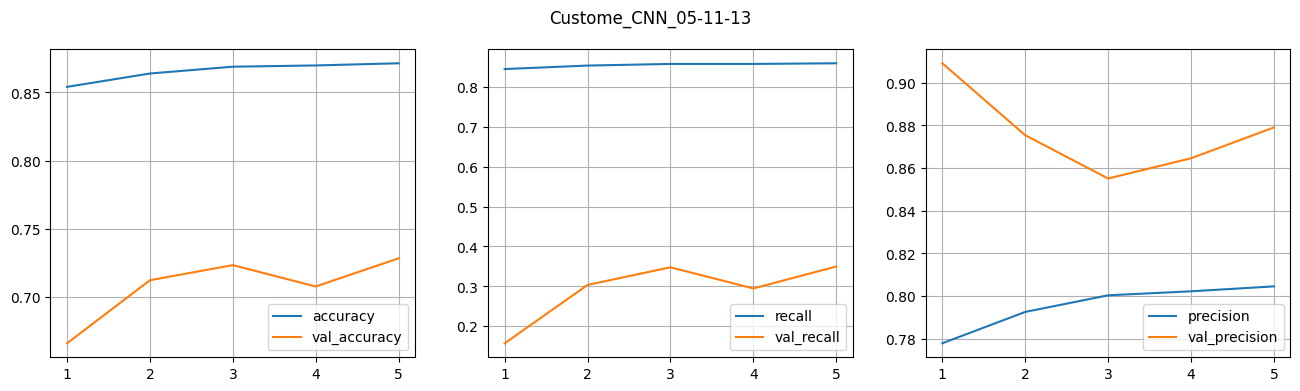

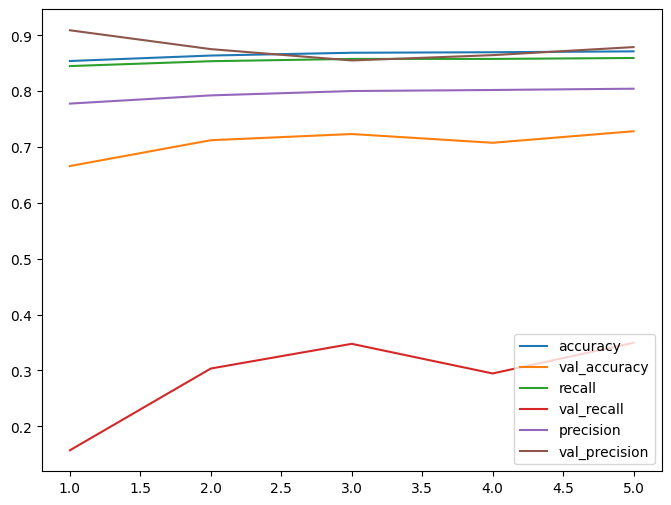

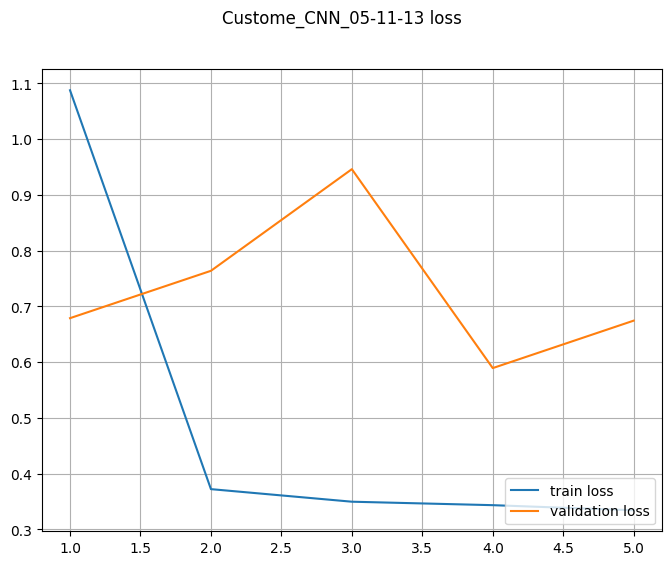

In [ ]:
history = ModelTraining(train_ds, val_ds, custom_model, show_summary=False,
              model_name=MODEL_NAME, optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS, output_bias=initial_bias,
              class_weights=class_weights, callbacks_list=callbacks_list, epochs=epochs)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
filepath = f'/content/{MODEL_NAME}_2_best_metric.keras'

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=3800,
    decay_rate=0.95
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, weight_decay=0.01)

custom_checkpoint = CustomCheckpoint(filepath=filepath, monitor_metric='val_auc')

callbacks_list = [EarlyStopping(monitor='val_auc', patience=8),
                  ModelCheckpoint(f'{MODEL_NAME}.keras', monitor='val_loss', save_best_only=True),
                  custom_checkpoint]

epochs=20

history = ModelTraining(train_ds, val_ds, custom_model, show_summary=False,
              model_name=MODEL_NAME, optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS, output_bias=initial_bias,
              class_weights=class_weights, callbacks_list=callbacks_list, epochs=epochs)

Custome_CNN_05-11-13
Epoch 1/20
3805/3805 ━━━━━━━━━━━━━━━━━━━━ 2044s 108ms/step - accuracy: 0.8594 - auc: 0.9308 - fn: 3808.6670 - fp: 4766.8594 - loss: 0.3351 - prc: 0.9057 - precision: 0.8071 - recall: 0.8153 - tn: 35274.0664 - tp: 19679.1797 - val_accuracy: 0.6863 - val_auc: 0.8420 - val_fn: 801.0000 - val_fp: 20.0000 - val_loss: 1.1220 - val_prc: 0.7949 - val_precision: 0.9156 - val_recall: 0.2132 - val_tn: 1579.0000 - val_tp: 217.0000
Epoch 2/20
3805/3805 ━━━━━━━━━━━━━━━━━━━━ 432s 99ms/step - accuracy: 0.8712 - auc: 0.9449 - fn: 3170.1750 - fp: 4652.9614 - loss: 0.3375 - prc: 0.9206 - precision: 0.8049 - recall: 0.8583 - tn: 33781.1328 - tp: 19307.6836 - val_accuracy: 0.7272 - val_auc: 0.8748 - val_fn: 668.0000 - val_fp: 46.0000 - val_loss: 0.5208 - val_prc: 0.8145 - val_precision: 0.8838 - val_recall: 0.3438 - val_tn: 1553.0000 - val_tp: 350.0000
Epoch 3/20
3805/3805 ━━━━━━━━━━━━━━━━━━━━ 441s 99ms/step - accuracy: 0.8732 - auc: 0.9463 - fn: 3154.9031 - fp: 4576.7158 - loss: 0.331

In [ ]:
data_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm")
show_dirs_len(data_dir)

.: 3
test: 2
test/other: 17549
test/melanoma: 1587
validation: 2
validation/other: 1599
validation/melanoma: 1018
train: 2
train/other: 64101
train/melanoma: 34637


In [ ]:
IM_SIZE = 256
BATCH_SIZE = 32
VERSION = generate_model_version_name()
MODEL_NAME = f"Custome_CNN_{VERSION}"
LEARNING_RATE = 1e-4

# if full train_ds
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "train",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  shuffle=True,
  batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "validation",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

# Configure the dataset for performance
train_ds = train_ds.shuffle(64).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# weight_0, weight_1 = binary_class_weights(train_ds)
weight_0, weight_1 = binary_class_weights_2(count_1, count_0)

class_weights = {0: weight_0, 1: weight_1}

print(f'Weight for class 0: {weight_0:.2f}')
print(f'Weight for class 1: {weight_1:.2f}')

initial_bias = initial_bias_calc_2(count_1, count_0)
print(f'initial_bias: {initial_bias}')

custom_model = Custom_CNN(input_shape=(IM_SIZE, IM_SIZE, 3), reduction=4, use_regularization=True, weight_decay=1e-2)

# custom_model.summary(show_trainable=True)

filepath = f'/content/{MODEL_NAME}_2_best_metric.keras'

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=3800,
    decay_rate=0.95
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, weight_decay=0.01)

custom_checkpoint = CustomCheckpoint(filepath=filepath, monitor_metric='val_auc')

callbacks_list = [EarlyStopping(monitor='val_auc', patience=8),
                  ModelCheckpoint(f'{MODEL_NAME}.keras', monitor='val_loss', save_best_only=True),
                  custom_checkpoint]

epochs=20

Found 98738 files belonging to 2 classes.
Found 2617 files belonging to 2 classes.
Found 19136 files belonging to 2 classes.
Weight for class 0: 0.77
Weight for class 1: 1.43
initial_bias: -0.6155374895659944


Custome_CNN_05-11-17
Epoch 1/20
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 378s 105ms/step - accuracy: 0.8358 - auc: 0.9068 - fn: 2576.0251 - fp: 4820.9043 - loss: 5.2990 - prc: 0.8408 - precision: 0.7341 - recall: 0.8241 - tn: 27268.6602 - tp: 14742.2051 - val_accuracy: 0.7352 - val_auc: 0.8662 - val_fn: 650.0000 - val_fp: 43.0000 - val_loss: 1.1674 - val_prc: 0.8030 - val_precision: 0.8954 - val_recall: 0.3615 - val_tn: 1556.0000 - val_tp: 368.0000
Epoch 2/20
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 312s 92ms/step - accuracy: 0.8744 - auc: 0.9450 - fn: 2030.8545 - fp: 4099.3306 - loss: 0.7857 - prc: 0.9052 - precision: 0.7856 - recall: 0.8810 - tn: 27984.5000 - tp: 15293.1553 - val_accuracy: 0.6890 - val_auc: 0.8710 - val_fn: 805.0000 - val_fp: 9.0000 - val_loss: 0.8109 - val_prc: 0.8107 - val_precision: 0.9595 - val_recall: 0.2092 - val_tn: 1590.0000 - val_tp: 213.0000
Epoch 3/20
3086/3086 ━━━━━━━━━━━━━━━━━━━━ 286s 92ms/step - accuracy: 0.8814 - auc: 0.9495 - fn: 1965.3485 - fp: 3857.8416 - loss: 0.4924 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

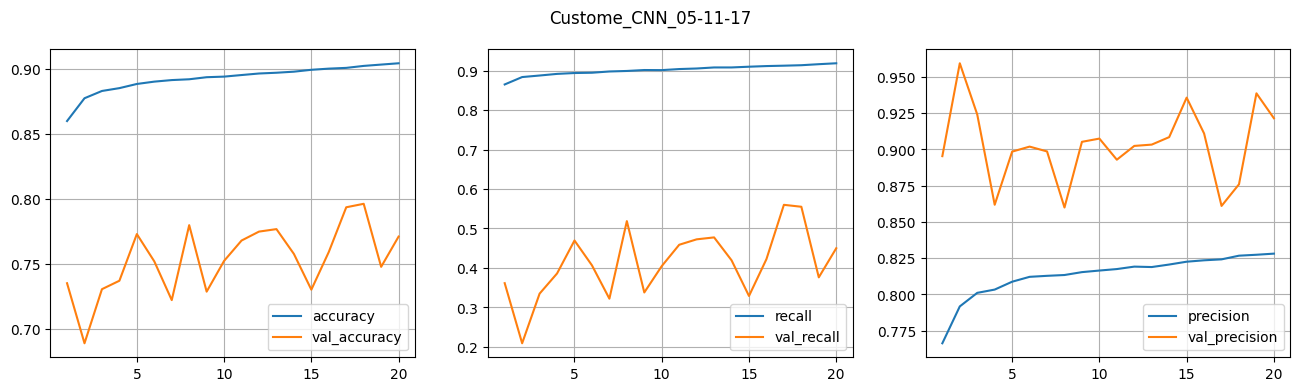

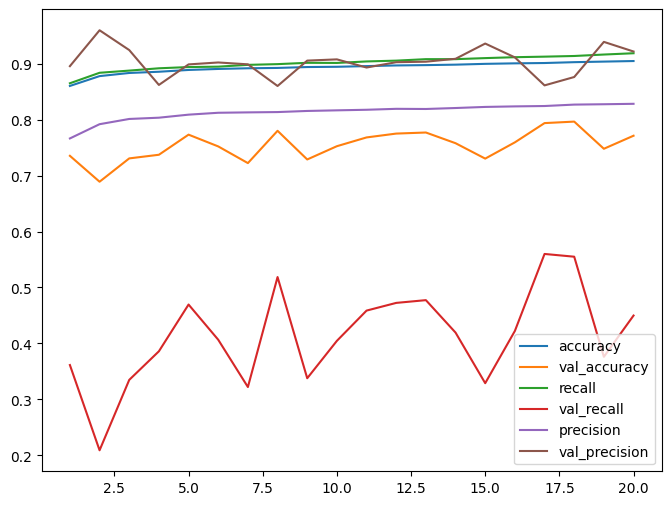

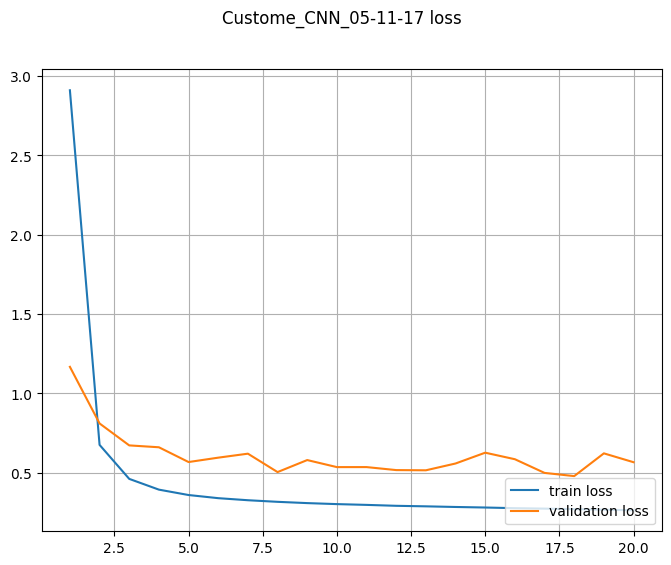

In [ ]:
history = ModelTraining(train_ds, val_ds, custom_model, show_summary=False,
              model_name=MODEL_NAME, optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(), metrics=METRICS, output_bias=initial_bias,
              class_weights=class_weights, callbacks_list=callbacks_list, epochs=epochs)

In [ ]:
custom_model.save_weights("custome_model_051117.weights.h5")

### Оцінка

In [ ]:
model_path = f"/content/{MODEL_NAME}.keras"
model_best_loss = keras.models.load_model(model_path, custom_objects={"ConvDeptConv": ConvDepthwiseConvBlock, "cbam": CBAM})

best_loss_model_res = ModelEvaluating(test_ds,
                           model_best_loss, model_name=MODEL_NAME,
                           metrics=METRICS)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ConvDeptConv1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ConvDeptConv2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'ConvDeptConv3', however the layer doe

598/598 ━━━━━━━━━━━━━━━━━━━━ 44s 63ms/step - accuracy: 0.9034 - auc: 0.8561 - fn: 422.8648 - fp: 483.2020 - loss: 0.2836 - prc: 0.4443 - precision: 0.4205 - recall: 0.4496 - tn: 8331.1504 - tp: 362.7296
loss :  0.2798241078853607
accuracy :  0.9065635204315186
precision :  0.4407079517841339
recall :  0.4706994295120239
tp :  747.0
fp :  948.0
tn :  16601.0
fn :  840.0
auc :  0.8611077070236206
prc :  0.4651466906070709
f1_beta :  0.464378957595131


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

перезберегти модель, якщо не завантажується

In [ ]:
custom_model = make_model(learning_rate=1e-4, loss_func=keras.losses.BinaryCrossentropy(), metrics=METRICS, model=custom_model, output_bias=None)

In [ ]:
custom_model.save('/content/Custom_CNN_05-11-17_.keras')

In [ ]:
model_path2 = f"/content/Custom_CNN_05-11-17_.keras"
model_best_metric = keras.models.load_model(model_path2, custom_objects={"ConvDeptConv": ConvDepthwiseConvBlock, "cbam": CBAM})

best_metric_model_res = ModelEvaluating(test_ds,
                           model_best_metric, model_name='CNN_05-11-07',
                           metrics=METRICS)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 202 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


598/598 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.9034 - auc: 0.8561 - fn: 422.8648 - fp: 483.2020 - loss: 0.2433 - prc: 0.4443 - precision: 0.4205 - recall: 0.4496 - tn: 8331.1504 - tp: 362.7296
loss :  0.2394837588071823
accuracy :  0.9065635204315186
precision :  0.4407079517841339
recall :  0.4706994295120239
tp :  747.0
fp :  948.0
tn :  16601.0
fn :  840.0
auc :  0.8611077070236206
prc :  0.4651466906070709
f1_beta :  0.464378957595131


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
IM_SIZE = 256
BATCH_SIZE = 32

MODEL_NAME = "CNN_05-11-07"

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

# test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 19136 files belonging to 2 classes.


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# перевизначити, щоб прибрати prefetch та отримати атрибут датасету file_paths, а також прибрати мітки, перемішування
test_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  label_mode=None,
  image_size=IM_SIZE,
  batch_size=BATCH_SIZE,
  shuffle=False)

Found 19136 files.


              precision    recall  f1-score   support

           0       0.95      0.95      0.95     17549
           1       0.44      0.47      0.46      1587

    accuracy                           0.91     19136
   macro avg       0.70      0.71      0.70     19136
weighted avg       0.91      0.91      0.91     19136

(0.9094482652181161, 0.9065635451505016, 0.9071084740602581, None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

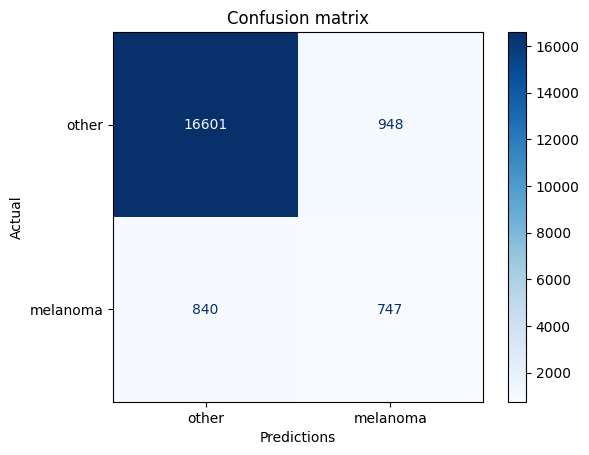

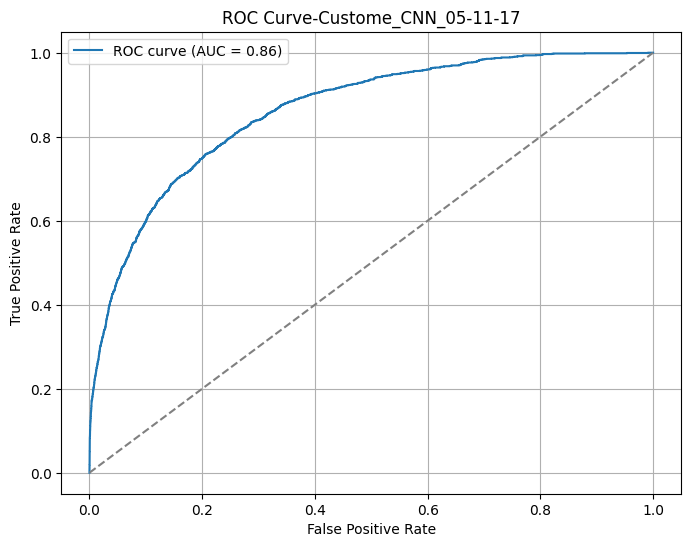

In [ ]:
prediction_df1 = ModelPredicting(test_dataset, model_best_loss, model_name=MODEL_NAME)

In [ ]:
prediction_df2 = ModelPredicting(test_dataset, model_best_metric, model_name=MODEL_NAME)

In [ ]:
# обробка тестових даних
test_data_dir = pathlib.Path('/content/full_ds_croppedtr_no_augm/test')
prepocess_to_crop(test_data_dir, center_ratio=0.5, threshold=70)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=BATCH_SIZE)

test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

With vignette /content/full_ds_croppedtr_no_augm/test/other: 2028
Without vignette /content/full_ds_croppedtr_no_augm/test/other: 15521
17549
With vignette /content/full_ds_croppedtr_no_augm/test/melanoma: 517
Without vignette /content/full_ds_croppedtr_no_augm/test/melanoma: 1070
1587
Found 19136 files belonging to 2 classes.


In [ ]:
best_model_res_cropped_ds = ModelEvaluating(test_ds,
                           model_best_loss, model_name=MODEL_NAME,
                           metrics=METRICS)

598/598 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.9119 - auc: 0.8382 - fn: 444.6578 - fp: 382.2404 - loss: 0.2799 - prc: 0.4498 - precision: 0.4637 - recall: 0.4248 - tn: 8432.1123 - tp: 340.9366
loss :  0.27684471011161804
accuracy :  0.9141408801078796
precision :  0.4806629717350006
recall :  0.4385633170604706
tp :  696.0
fp :  752.0
tn :  16797.0
fn :  891.0
auc :  0.8432958722114563
prc :  0.46400779485702515
f1_beta :  0.44638275010913164


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

На тест датасет після обробки (обрізання чорних країв) модель показала гіршу здатність розпізнавати цільовий клас.

Found 19136 files.
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     17549
           1       0.48      0.44      0.46      1587

    accuracy                           0.91     19136
   macro avg       0.72      0.70      0.71     19136
weighted avg       0.91      0.91      0.91     19136

(0.9107344283218947, 0.9141408862876255, 0.913401065848185, None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

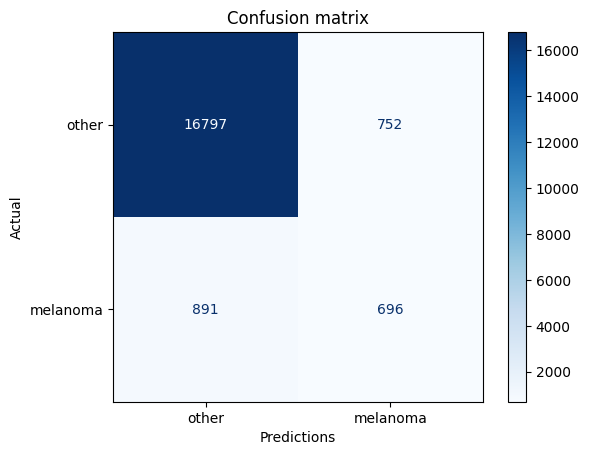

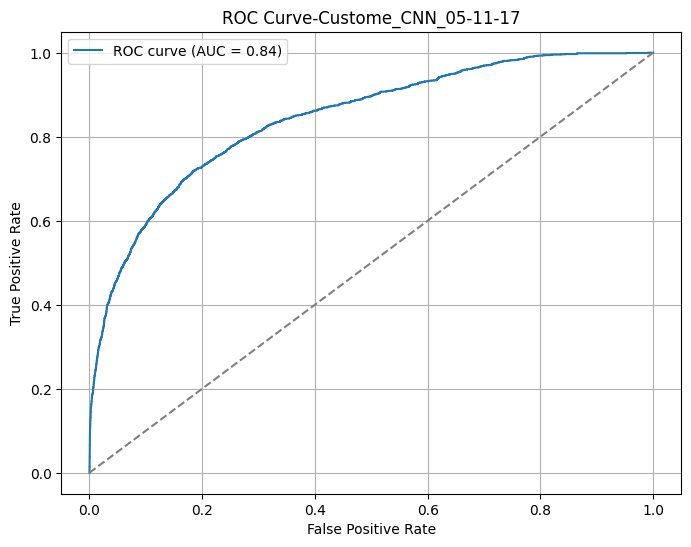

In [ ]:
# перевизначити, щоб прибрати prefetch та отримати атрибут датасету file_paths, а також прибрати мітки, перемішування
test_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  label_mode=None,
  image_size=IM_SIZE,
  batch_size=BATCH_SIZE,
  shuffle=False)

prediction_df1 = ModelPredicting(test_dataset, model_best_loss, model_name=MODEL_NAME)

## Експеримент з динамічним датасетом + додаткові валідаційні дані

!визначення Метрик, Шарів, Моделі

In [ ]:
data_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm")
show_dirs_len(data_dir)

.: 3
test: 2
test/other: 17549
test/melanoma: 1587
validation: 2
validation/other: 2107
validation/melanoma: 1113
train: 2
train/other: 102562
train/melanoma: 24450


In [ ]:
IM_SIZE = 256
BATCH_SIZE = 32
VERSION = generate_model_version_name()
MODEL_NAME = f"Custome_CNN_{VERSION}"
# LEARNING_RATE = 9e-5
LEARNING_RATE = 1e-4

In [ ]:
MODEL_NAME

'Custome_CNN_05-15-19'

In [ ]:
n, m = (0.3, 0.6)
count_1 = int(len(os.listdir(data_dir / "train/melanoma")) *  m)
count_0 = int(len(os.listdir(data_dir / "train/other")) * n)

weight_0, weight_1 = binary_class_weights_2(count_1, count_0)
class_weights = {0: weight_0, 1: weight_1}

print(f'Weight for class 0: {weight_0:.2f}')
print(f'Weight for class 1: {weight_1:.2f}')

initial_bias = initial_bias_calc_2(count_1, count_0)
print(f'initial_bias: {initial_bias}')

Weight for class 0: 0.74
Weight for class 1: 1.55
initial_bias: -0.7406705966915336


In [ ]:
custom_model = Custom_CNN(input_shape=(IM_SIZE, IM_SIZE, 3), reduction=4)
custom_model = make_model(learning_rate=LEARNING_RATE, loss_func=keras.losses.BinaryCrossentropy(), metrics=METRICS, model=custom_model, output_bias=initial_bias)
model_path = f"/content/{MODEL_NAME}.keras"
# model = keras.models.load_model(model_path, custom_objects={"ConvDeptConv": ConvDepthwiseConvBlock, "cbam": CBAM})

In [ ]:
custom_model.summary()

Model: "custome_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resize_rescale      │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ resize_rescale[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 128, 128,  │        320 │ activation_1[0][… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ConvDeptConv1       │ (None, 64, 64,    │     38,240 │ max_pooling2d[0]… │
│ (ConvDepthwiseConv… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ ConvDeptConv1[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cbam1 (CBAM)        │ (None, 32, 32,    │      1,171 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      1,056 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ cbam1[0][0],    

 Total params: 803,069 (3.06 MB)

 Trainable params: 798,013 (3.04 MB)

 Non-trainable params: 5,056 (19.75 KB)

In [ ]:
# filepath = f'/content/{MODEL_NAME}.keras'

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=LEARNING_RATE,
#     decay_steps=7400,
#     decay_rate=0.95
# )

# optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, weight_decay=0.01)

# custom_checkpoint = CustomCheckpoint(filepath=filepath, monitor_metric='val_auc')

# callbacks_list = [EarlyStopping(monitor='val_auc', patience=8),
#                   ModelCheckpoint(f'{MODEL_NAME}.keras', monitor='val_loss', save_best_only=True),
#                   custom_checkpoint]



In [ ]:
import gc

def fit_with_ds_change(model, update_train_ds_fn, val_ds_fn, cycles, callbacks_list,
                  val_metric_threshold, mode_metric='max', monitor_metric='val_prc',
                  epochs_per_cycle=1, class_weight = None,
                  best_modelpath='best_modelpath.keras', cycle_best_modelpath='cycle_best_modelpath.keras'):
    change_dataset = True
    best_val_metric = val_metric_threshold
    if epochs_per_cycle > 1:
        callbacks_list.append(ModelCheckpoint(cycle_best_modelpath, monitor=monitor_metric, save_best_only=True))

    for cycle in range(cycles):
        print(f"epoch{cycle*epochs_per_cycle + 1}/{cycles*epochs_per_cycle}")
        if change_dataset:
            if 'train_ds' in locals():
                del train_ds
            if 'val_ds' in locals():
                del val_ds
            if 'history' in locals():
                del history
            gc.collect()
            train_ds = update_train_ds_fn()
            val_ds = val_ds_fn()

        change_dataset = True

        history = model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=epochs_per_cycle,
                            callbacks=callbacks_list,
                            class_weight=class_weights)

        val_metrics = history.history[monitor_metric]
        current_best_metric = max(val_metrics)

        if (mode_metric == 'max' and current_best_metric > best_val_metric) or (mode_metric == 'min' and current_best_metric < best_val_metric):
            best_val_metric = current_best_metric
            if epochs_per_cycle > 1:
                model.load_weights(cycle_best_modelpath)
            model.save(best_modelpath)
            change_dataset = False
            print(f"{monitor_metric}: {current_best_metric:.4f}")

    return best_val_metric

def create_val_ds(directory, class_names, batch_size, seed=None):
    val_ds = tf.keras.utils.image_dataset_from_directory(
            directory,
            class_names=class_names,
            seed=seed,
            batch_size=batch_size)

    return val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
epochs = 10
epochs_per_cycle = 5
monitor_metric = 'val_prc'
# змінювати
val_metric_threshold = 0.5
best_modelpath = f'/content/{MODEL_NAME}.keras'
cycle_best_modelpath = f'/content/{MODEL_NAME}_tmp.keras'
class_names = {"other": np.int32(0), "melanoma": np.int32(1)}
class_proportions = {class_names["other"]: n, class_names["melanoma"]: m}

metrics_logger = MetricsLogger(filepath=f"metrics_logs_{MODEL_NAME}.csv")
callbacks_list = [metrics_logger]

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=2840,
    decay_rate=0.95
)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, weight_decay=0.01)

update_train_ds_fn = lambda: stratified_dataset_from_directory(data_dir / "train",
                                            class_names,
                                            BATCH_SIZE,
                                            balanced=False,
                                            image_size=(IM_SIZE, IM_SIZE),
                                            shuffle=True,
                                            class_proportions=class_proportions,
                                            my_seed=None)



val_ds_fn = lambda: create_val_ds(data_dir / "validation", ["other", "melanoma"], BATCH_SIZE, seed=123)

test_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir / "test",
        class_names=["other", "melanoma"],
        seed=123,
        # image_size=(IM_SIZE, IM_SIZE),
        batch_size=BATCH_SIZE)


Found 19136 files belonging to 2 classes.


In [ ]:
best_val_metric = fit_with_ds_change(custom_model, update_train_ds_fn, val_ds_fn, epochs, callbacks_list,
                                    val_metric_threshold=val_metric_threshold, mode_metric='max', monitor_metric='val_prc',
                                    epochs_per_cycle=epochs_per_cycle, class_weight=class_weights,
                                    best_modelpath=best_modelpath, cycle_best_modelpath=cycle_best_modelpath)

epoch1/20
Found 102562 files of class other
Found 24450 files of class melanoma
Found 3220 files belonging to 2 classes.
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 243s 136ms/step - accuracy: 0.7471 - auc: 0.8179 - fn: 1839.6572 - fp: 3479.8176 - loss: 0.5133 - prc: 0.7040 - precision: 0.5940 - recall: 0.7109 - tn: 11864.5801 - tp: 5567.9199 - val_accuracy: 0.7578 - val_auc: 0.8329 - val_fn: 695.0000 - val_fp: 85.0000 - val_loss: 0.5495 - val_prc: 0.7421 - val_precision: 0.8310 - val_recall: 0.3756 - val_tn: 2022.0000 - val_tp: 418.0000
val_prc: 0.7421
epoch2/20
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 152s 107ms/step - accuracy: 0.8054 - auc: 0.8932 - fn: 1438.4694 - fp: 2939.9192 - loss: 0.4105 - prc: 0.8158 - precision: 0.6676 - recall: 0.8061 - tn: 12403.4561 - tp: 5970.1304 - val_accuracy: 0.7829 - val_auc: 0.8593 - val_fn: 579.0000 - val_fp: 120.0000 - val_loss: 0.4542 - val_prc: 0.7744 - val_precision: 0.8165 - val_recall: 0.4798 - val_tn: 1987.0000 - val_tp: 534.0000
val_prc: 0.7744
epoch3/20
1420/1

In [ ]:
# custom_model = Custom_CNN(input_shape=(IM_SIZE, IM_SIZE, 3), reduction=4)
MODEL_NAME = 'Custome_CNN_05-15-19'
model_path = f"/content/Custome_CNN_05-15-19.keras"
custom_model = keras.models.load_model(model_path, custom_objects={"ConvDeptConv": ConvDepthwiseConvBlock, "cbam": CBAM})
# custom_model = make_model(learning_rate=LEARNING_RATE, loss_func=keras.losses.BinaryCrossentropy(), metrics=METRICS, model=custom_model, output_bias=initial_bias)

In [ ]:
best_val_metric = fit_with_ds_change(custom_model, update_train_ds_fn, val_ds_fn, epochs, callbacks_list,
                                    val_metric_threshold=val_metric_threshold, mode_metric='max', monitor_metric='val_prc',
                                    epochs_per_cycle=epochs_per_cycle, class_weight=class_weights,
                                    best_modelpath=best_modelpath, cycle_best_modelpath=cycle_best_modelpath)

epoch1/20
Found 102562 files of class other
Found 24450 files of class melanoma
Found 3220 files belonging to 2 classes.
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 222s 131ms/step - accuracy: 0.8617 - auc: 0.9464 - fn: 844.6833 - fp: 2330.8247 - loss: 0.2924 - prc: 0.9015 - precision: 0.7405 - recall: 0.8873 - tn: 13038.5723 - tp: 6537.8945 - val_accuracy: 0.7935 - val_auc: 0.8751 - val_fn: 590.0000 - val_fp: 75.0000 - val_loss: 0.5275 - val_prc: 0.8132 - val_precision: 0.8746 - val_recall: 0.4699 - val_tn: 2032.0000 - val_tp: 523.0000
val_prc: 0.8132
epoch2/20
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 151s 106ms/step - accuracy: 0.8745 - auc: 0.9536 - fn: 737.5250 - fp: 2125.2239 - loss: 0.2729 - prc: 0.9130 - precision: 0.7577 - recall: 0.9036 - tn: 13246.7568 - tp: 6642.4692 - val_accuracy: 0.8081 - val_auc: 0.8757 - val_fn: 478.0000 - val_fp: 140.0000 - val_loss: 0.4778 - val_prc: 0.8073 - val_precision: 0.8194 - val_recall: 0.5705 - val_tn: 1967.0000 - val_tp: 635.0000
epoch3/20
Found 102562 files of cl

In [ ]:
best_val_metric = fit_with_ds_change(custom_model, update_train_ds_fn, val_ds_fn, epochs, callbacks_list,
                                    val_metric_threshold=val_metric_threshold, mode_metric='max', monitor_metric='val_prc',
                                    epochs_per_cycle=epochs_per_cycle, class_weight=class_weights,
                                    best_modelpath=best_modelpath, cycle_best_modelpath=cycle_best_modelpath)

epoch1/20
Found 102562 files of class other
Found 24450 files of class melanoma
Found 3220 files belonging to 2 classes.
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 230s 135ms/step - accuracy: 0.8733 - auc: 0.9537 - fn: 736.4138 - fp: 2178.4082 - loss: 0.2714 - prc: 0.9117 - precision: 0.7544 - recall: 0.9011 - tn: 13208.4561 - tp: 6628.6968 - val_accuracy: 0.8087 - val_auc: 0.8760 - val_fn: 458.0000 - val_fp: 158.0000 - val_loss: 0.4658 - val_prc: 0.8087 - val_precision: 0.8057 - val_recall: 0.5885 - val_tn: 1949.0000 - val_tp: 655.0000
epoch2/20
Found 102562 files of class other
Found 24450 files of class melanoma
Found 3220 files belonging to 2 classes.
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 150s 105ms/step - accuracy: 0.8779 - auc: 0.9569 - fn: 736.4194 - fp: 2073.9641 - loss: 0.2623 - prc: 0.9158 - precision: 0.7626 - recall: 0.9008 - tn: 13349.3623 - tp: 6592.2285 - val_accuracy: 0.7919 - val_auc: 0.8732 - val_fn: 571.0000 - val_fp: 99.0000 - val_loss: 0.5576 - val_prc: 0.8097 - val_precision: 0.8456

нестабільне навчання

In [ ]:
from google.colab import files
files.download(f'/content/metrics_logs_{MODEL_NAME}.csv')
files.download(f'/content/{MODEL_NAME}.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

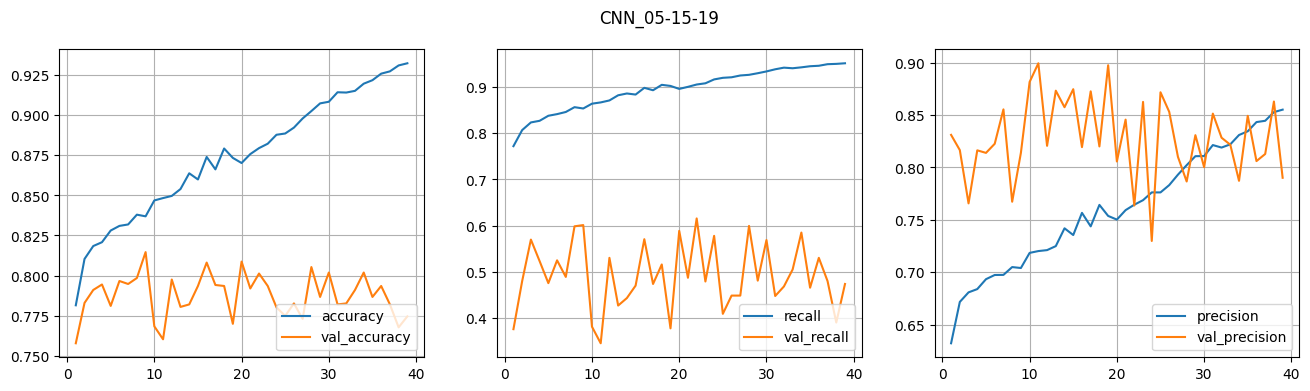

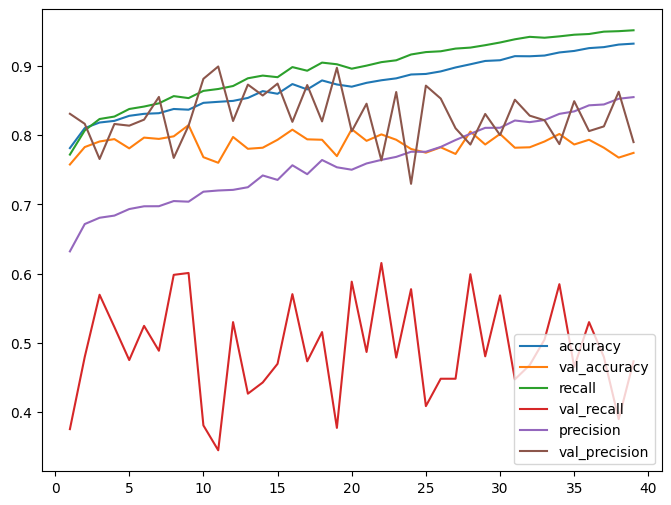

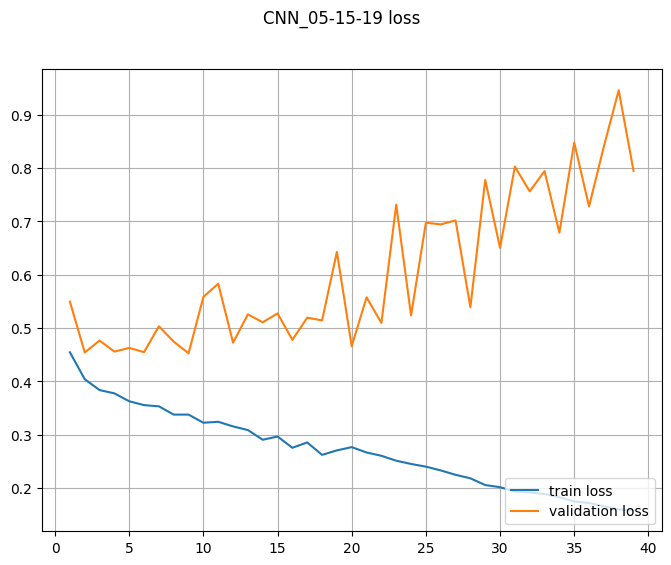

In [ ]:
# df_history = pd.read_csv(f'/content/metrics_logs_{MODEL_NAME}.csv')
# plot_scores (df_history[df_history.epoch != 'epoch'], MODEL_NAME, ['accuracy', 'recall', 'precision'])
# plot_loss(df_history[df_history.epoch != 'epoch'], MODEL_NAME)

df_history = pd.read_csv(f'/content/metrics_logs_Custome_CNN_05-15-19.csv')
plot_scores (df_history, 'CNN_05-15-19', ['accuracy', 'recall', 'precision'])
plot_loss(df_history, 'CNN_05-15-19')

In [ ]:
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
last_model_res = ModelEvaluating(test_ds,
                           custom_model, model_name=MODEL_NAME+'last',
                           metrics=METRICS)

598/598 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.8906 - auc: 0.7712 - fn: 461.2254 - fp: 587.1335 - loss: 0.3681 - prc: 0.3297 - precision: 0.3598 - recall: 0.4158 - tn: 8227.2188 - tp: 324.3690
loss :  0.3576768636703491
accuracy :  0.8900501728057861
precision :  0.35757574439048767
recall :  0.4089477062225342
tp :  649.0
fp :  1166.0
tn :  16383.0
fn :  938.0
auc :  0.7788434028625488
prc :  0.3473491668701172
f1_beta :  0.3975254209731197


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_path = f"/content/{MODEL_NAME}.keras"
best_metric_model = keras.models.load_model(model_path, custom_objects={"ConvDeptConv": ConvDepthwiseConvBlock, "cbam": CBAM})

best_metric_model_res = ModelEvaluating(test_ds,
                           best_metric_model, model_name=MODEL_NAME,
                           metrics=METRICS)

598/598 ━━━━━━━━━━━━━━━━━━━━ 31s 42ms/step - accuracy: 0.9168 - auc: 0.8338 - fn: 496.4591 - fp: 286.8715 - loss: 0.2367 - prc: 0.4101 - precision: 0.4948 - recall: 0.3625 - tn: 8526.8701 - tp: 289.7462
loss :  0.23194698989391327
accuracy :  0.9186872839927673
precision :  0.5138022899627686
recall :  0.3635790944099426
tp :  577.0
fp :  546.0
tn :  17003.0
fn :  1010.0
auc :  0.8389332890510559
prc :  0.42206674814224243
f1_beta :  0.3861598280902254


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Навчання зі зміною датасету після декількох епох

In [ ]:
best_val_metric = fit_with_ds_change(custom_model, update_train_ds_fn, val_ds_fn, epochs, callbacks_list,
                                    val_metric_threshold=val_metric_threshold, mode_metric='max', monitor_metric='val_auc',
                                    epochs_per_cycle=epochs_per_cycle, class_weight=class_weights,
                                    best_modelpath=best_modelpath, cycle_best_modelpath=cycle_best_modelpath)

epoch1/50
Found 102562 files of class other
Found 24450 files of class melanoma
Found 3220 files belonging to 2 classes.
Epoch 1/5
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 237s 134ms/step - accuracy: 0.7515 - auc: 0.8276 - fn: 1819.1464 - fp: 3447.4377 - loss: 0.5013 - prc: 0.7055 - precision: 0.5926 - recall: 0.7160 - tn: 11962.5049 - tp: 5522.8853 - val_accuracy: 0.7665 - val_auc: 0.8360 - val_fn: 501.0000 - val_fp: 251.0000 - val_loss: 0.4839 - val_prc: 0.7326 - val_precision: 0.7092 - val_recall: 0.5499 - val_tn: 1856.0000 - val_tp: 612.0000
Epoch 2/5
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 147s 103ms/step - accuracy: 0.8101 - auc: 0.8971 - fn: 1347.9937 - fp: 2991.6179 - loss: 0.4017 - prc: 0.8163 - precision: 0.6686 - recall: 0.8192 - tn: 12417.6543 - tp: 5994.7085 - val_accuracy: 0.7689 - val_auc: 0.8403 - val_fn: 657.0000 - val_fp: 87.0000 - val_loss: 0.4904 - val_prc: 0.7526 - val_precision: 0.8398 - val_recall: 0.4097 - val_tn: 2020.0000 - val_tp: 456.0000
Epoch 3/5
1420/1420 ━━━━━━━━━━━━━━━━━━

In [ ]:
data_dir = pathlib.Path("/content/full_ds_croppedtr_no_augm")
show_dirs_len(data_dir)

.: 3
test: 2
test/other: 17549
test/melanoma: 1587
validation: 2
validation/other: 2107
validation/melanoma: 1113
train: 2
train/other: 102562
train/melanoma: 24450


In [ ]:
n, m = (0.28, 0.8)
count_1 = int(len(os.listdir(data_dir / "train/melanoma")) *  m)
count_0 = int(len(os.listdir(data_dir / "train/other")) * n)

weight_0, weight_1 = binary_class_weights_2(count_1, count_0)
class_weights = {0: weight_0, 1: weight_1}

print(f'Weight for class 0: {weight_0:.2f}')
print(f'Weight for class 1: {weight_1:.2f}')

initial_bias = initial_bias_calc_2(count_1, count_0)
print(f'initial_bias: {initial_bias}')

Weight for class 0: 0.84
Weight for class 1: 1.23
initial_bias: -0.38400261729284557


In [ ]:
model_path = f"/content/Custome_CNN_05-16-11.keras"
custom_model = keras.models.load_model(model_path, custom_objects={"ConvDeptConv": ConvDepthwiseConvBlock, "cbam": CBAM})

In [ ]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 16
IM_SIZE = 256
MODEL_NAME = "Custome_CNN_05-16-11"
epochs = 10
epochs_per_cycle = 3
monitor_metric = 'val_auc'
# змінювати
val_metric_threshold = 0.8791
best_modelpath = '/content/Custome_CNN_05-16-11.keras'
cycle_best_modelpath = '/content/Custome_CNN_05-16-11_tmp.keras'
# best_modelpath = f'/content/{MODEL_NAME}.keras'
# cycle_best_modelpath = f'/content/{MODEL_NAME}_tmp.keras'
class_names = {"other": np.int32(0), "melanoma": np.int32(1)}
class_proportions = {class_names["other"]: n, class_names["melanoma"]: m}

metrics_logger = MetricsLogger(filepath=f"metrics_logs_Custome_CNN_05-16-11.csv")
callbacks_list = [metrics_logger]

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=4260,
    decay_rate=0.95
)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, weight_decay=0.01)

update_train_ds_fn = lambda: stratified_dataset_from_directory(data_dir / "train",
                                            class_names,
                                            BATCH_SIZE,
                                            balanced=False,
                                            image_size=(IM_SIZE, IM_SIZE),
                                            shuffle=True,
                                            class_proportions=class_proportions,
                                            my_seed=None)



val_ds_fn = lambda: create_val_ds(data_dir / "validation", ["other", "melanoma"], BATCH_SIZE, seed=123)

test_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir / "test",
        class_names=["other", "melanoma"],
        seed=123,
        # image_size=(IM_SIZE, IM_SIZE),
        batch_size=BATCH_SIZE)


Found 19136 files belonging to 2 classes.


In [ ]:
best_val_metric = fit_with_ds_change(custom_model, update_train_ds_fn, val_ds_fn, epochs, callbacks_list,
                                    val_metric_threshold=val_metric_threshold, mode_metric='max', monitor_metric='val_auc',
                                    epochs_per_cycle=epochs_per_cycle, class_weight=class_weights,
                                    best_modelpath=best_modelpath, cycle_best_modelpath=cycle_best_modelpath)

epoch1/30
Found 102562 files of class other
Found 24450 files of class melanoma
Found 3220 files belonging to 2 classes.
Epoch 1/3
3018/3018 ━━━━━━━━━━━━━━━━━━━━ 251s 72ms/step - accuracy: 0.8167 - auc: 0.9048 - fn: 1773.1954 - fp: 2628.3909 - loss: 0.3876 - prc: 0.8751 - precision: 0.7543 - recall: 0.8177 - tn: 11716.8730 - tp: 8041.5283 - val_accuracy: 0.8081 - val_auc: 0.8767 - val_fn: 477.0000 - val_fp: 141.0000 - val_loss: 0.4467 - val_prc: 0.8063 - val_precision: 0.8185 - val_recall: 0.5714 - val_tn: 1966.0000 - val_tp: 636.0000
Epoch 2/3
3018/3018 ━━━━━━━━━━━━━━━━━━━━ 190s 63ms/step - accuracy: 0.8229 - auc: 0.9121 - fn: 1614.3578 - fp: 2632.1274 - loss: 0.3722 - prc: 0.8838 - precision: 0.7553 - recall: 0.8355 - tn: 11709.3223 - tp: 8204.1807 - val_accuracy: 0.8022 - val_auc: 0.8661 - val_fn: 501.0000 - val_fp: 136.0000 - val_loss: 0.4481 - val_prc: 0.7972 - val_precision: 0.8182 - val_recall: 0.5499 - val_tn: 1971.0000 - val_tp: 612.0000
Epoch 3/3
3018/3018 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# custom_model.save("/content/Custome_CNN_05-16-11_last.keras")

In [ ]:
MODEL_NAME = 'Custome_CNN_05-16-11'

In [ ]:
model_res = ModelEvaluating(test_ds,
                           custom_model, model_name=MODEL_NAME,
                           metrics=METRICS)

598/598 ━━━━━━━━━━━━━━━━━━━━ 44s 59ms/step - accuracy: 0.8691 - auc: 0.8138 - fn: 406.9900 - fp: 813.5125 - loss: 0.3276 - prc: 0.2889 - precision: 0.3072 - recall: 0.4653 - tn: 8000.8398 - tp: 378.6043
loss :  0.31961172819137573
accuracy :  0.8744251728057861
precision :  0.3271186351776123
recall :  0.4864524304866791
tp :  772.0
fp :  1588.0
tn :  15961.0
fn :  815.0
auc :  0.822899341583252
prc :  0.2965869605541229
f1_beta :  0.4432705555521973


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Found 19136 files.
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     17549
           1       0.33      0.49      0.39      1587

    accuracy                           0.87     19136
   macro avg       0.64      0.70      0.66     19136
weighted avg       0.90      0.87      0.89     19136

(0.8996438094749034, 0.8744251672240803, 0.878257234034347, None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

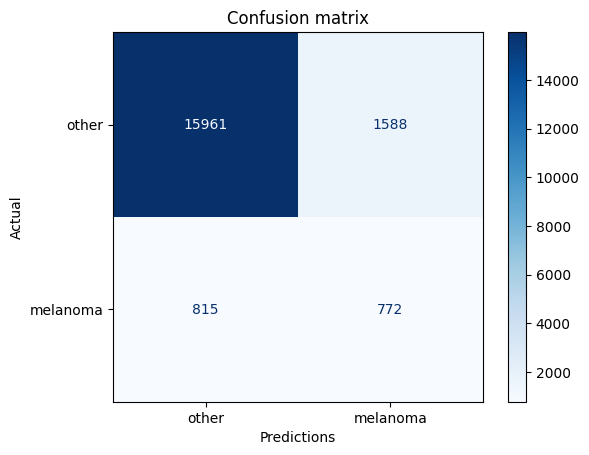

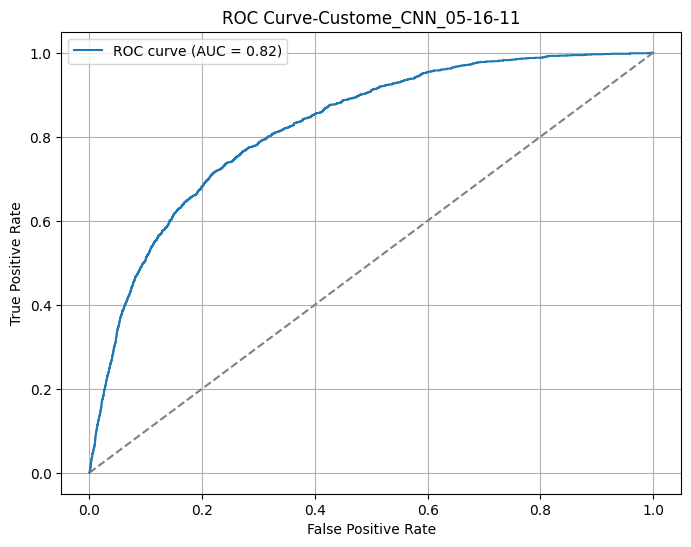

In [ ]:
# перевизначити, щоб прибрати prefetch та отримати атрибут датасету file_paths, а також прибрати мітки, перемішування
test_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir / "test",
  label_mode=None,
  image_size=(256, 256),
  batch_size=BATCH_SIZE,
  shuffle=False)

prediction_df = ModelPredicting(test_dataset, custom_model, model_name=MODEL_NAME)

Після обробки зображень

In [ ]:
# обробка тестових даних
test_data_dir = pathlib.Path('/content/full_ds_croppedtr_no_augm/test')
prepocess_to_crop(test_data_dir, center_ratio=0.5, threshold=70)

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
  class_names=["other", "melanoma"],
  seed=123,
  # image_size=(IM_SIZE, IM_SIZE),
  batch_size=32)

test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

model_res = ModelEvaluating(test_ds,
                           custom_model, model_name=MODEL_NAME,
                           metrics=METRICS)

With vignette /content/full_ds_croppedtr_no_augm/test/other: 2028
Without vignette /content/full_ds_croppedtr_no_augm/test/other: 15521
17549
With vignette /content/full_ds_croppedtr_no_augm/test/melanoma: 517
Without vignette /content/full_ds_croppedtr_no_augm/test/melanoma: 1070
1587
Found 19136 files belonging to 2 classes.
598/598 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.8614 - auc: 0.8238 - fn: 375.3105 - fp: 932.2137 - loss: 0.3494 - prc: 0.2747 - precision: 0.3005 - recall: 0.5098 - tn: 7882.1387 - tp: 410.2838
loss :  0.3447457551956177
accuracy :  0.8647052645683289
precision :  0.31221890449523926
recall :  0.5248897075653076
tp :  833.0
fp :  1835.0
tn :  15714.0
fn :  754.0
auc :  0.8268700242042542
prc :  0.279339462518692
f1_beta :  0.4619565145304572


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
tf.keras.backend.clear_session()